In [1]:
import pandas as pd
import numpy as np

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000

In [2]:
train = pd.read_csv('../data/CAX_MortgageModeling_Train.csv')

In [3]:
train.head(3)

,Unique_ID,MORTGAGE NUMBER,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PAYMENT FREQUENCY,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT
0,CAX_Train_1,1,900000,5429,61.98,65.00,71.63,360,1040000.0,4.0,Refinance,Monthly,Single Detached,12,L4C,Under 25,Male,108000,8,44-45,681,FUNDED
1,CAX_Train_2,2,386000,2179,35.22,74.29,40.65,360,390000.0,4.5,Refinance,Monthly,Single Detached,12,L9T,70 and over,Male,78000,2,56,710,FUNDED
2,CAX_Train_3,3,531000,2152,30.97,80.00,35.41,360,424800.0,3.5,Purchase,Monthly,Single Detached,6,M1N,35-39,Female,87000,2,72,709,FUNDED


In [4]:
train.RESULT = train.RESULT.apply(lambda x: 1 if x == 'FUNDED' else 0)

In [5]:
train.RESULT = train.RESULT.apply(lambda x: 1-x)

In [6]:
target = train.RESULT

In [7]:
test = pd.read_csv('../data/CAX_MortgageModeling_Test.csv')

In [8]:
test.head(3)

,Unique_ID,MORTGAGE NUMBER,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PAYMENT FREQUENCY,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT
0,CAX_Test_1,45643,430000,1861,34.51,75.00,35.60,360,322500.0,4.25,Refinance,Monthly,High Rise,24,M9B,45-49,Male,76000,8,23,834,NaN
1,CAX_Test_2,45644,676000,1032,37.18,55.51,37.50,360,375000.0,5.00,Purchase,Bi-Weekly,Semi-Detached,12,M3N,55-59,Female,75000,2,56,804,NaN
2,CAX_Test_3,45645,418000,949,23.30,79.90,32.88,360,334000.0,4.75,Refinance,Bi-Weekly,Single Detached,60,K2H,30-34,Male,70000,8,72,730,NaN


In [9]:
test_id = test.Unique_ID

In [10]:
print (train.shape, test.shape)

(45642, 22) (15214, 22)


In [11]:
train_len = train.shape[0]
traincols = list(train.columns[2:-1])

In [12]:
traincols

['PROPERTY VALUE',
 'MORTGAGE PAYMENT',
 'GDS',
 'LTV',
 'TDS',
 'AMORTIZATION',
 'MORTGAGE AMOUNT',
 'RATE',
 'MORTGAGE PURPOSE',
 'PAYMENT FREQUENCY',
 'PROPERTY TYPE',
 'TERM',
 'FSA',
 'AGE RANGE',
 'GENDER',
 'INCOME',
 'INCOME TYPE',
 'NAICS CODE',
 'CREDIT SCORE']

In [13]:
data = pd.concat([train[traincols+['RESULT']],test[traincols+['RESULT']]],axis=0)

In [14]:
data['GDS'] = np.abs(data['GDS'])
data['GDS'] = np.clip(data.GDS,0,100)

In [15]:
data['TDS'] = np.abs(data['TDS'])
data['TDS'] = np.clip(data.TDS,0,100)

In [16]:
data['GDS'] = data['GDS']/100
data['LTV'] = data['LTV']/100
data['TDS'] = data['TDS']/100
data['RATE'] = data['RATE']/100

In [17]:
data['ANNUALIZED HOUSING EXPENSE'] = data['GDS'] * data['INCOME']
data['MORTGAGE RATIO'] = data['MORTGAGE AMOUNT']/data['PROPERTY VALUE']
data['OTHER EXPENSE'] = data['INCOME'] * data['TDS'] - data['ANNUALIZED HOUSING EXPENSE']
data['RENT INCOME'] = data.apply(lambda x: np.abs(x['OTHER EXPENSE']) if x.GDS > x.TDS else 0, axis=1)
data['OTHER EXPENSE'] = np.clip(data['OTHER EXPENSE'],0,data['OTHER EXPENSE'].max())

In [18]:
def f(x):
    if x['PAYMENT FREQUENCY'] in ['Bi-Weekly','Bi-Weekly Accelerated','Semi-Monthly'] :
        return 2
    elif x['PAYMENT FREQUENCY'] in ['Weekly','Weekly Accelerated']:
        return 4
    else:
        return x['PAYMENT FREQUENCY IN MONTHS']
data['PAYMENT FREQUENCY IN MONTHS'] = 1
data['PAYMENT FREQUENCY IN MONTHS'] = data.apply(lambda x: f(x), axis=1)

In [19]:
data['MORTGAGE PAYMENT'] = data['PAYMENT FREQUENCY IN MONTHS'] * data['MORTGAGE PAYMENT']

In [20]:
data['ACTUAL MORTGAGE PAYMENT'] = data.apply(lambda x: x['MORTGAGE AMOUNT'] * np.exp(x.RATE*x.AMORTIZATION*1.0/12), axis=1)
data['TOTAL INTEREST'] = data.apply(lambda x: x['ACTUAL MORTGAGE PAYMENT'] - x['MORTGAGE AMOUNT'], axis=1)

In [21]:
data['MORTGAGE AMOUNT PER INCOME'] = data['MORTGAGE AMOUNT']/data['INCOME']
data['MORTGAGE PAYMENT PER INCOME'] = data['MORTGAGE PAYMENT']*12/data['INCOME']
data['PROPERTY VALUE PER INCOME'] = data['PROPERTY VALUE']/data['INCOME']
data['TOTAL INTEREST PER INCOME'] = data['TOTAL INTEREST']/data['INCOME']
data['OTHER EXPENSE PER INCOME'] = data['OTHER EXPENSE']/data['INCOME']
data['ANNUALIZED HOUSING EXPENSE PER INCOME'] = data['ANNUALIZED HOUSING EXPENSE']/data['INCOME']

In [22]:
data['ACTUAL MORTGAGE PAYMENT BY MORTGAGE'] = data['ACTUAL MORTGAGE PAYMENT']/data['MORTGAGE AMOUNT']

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
data.head(10)

,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PAYMENT FREQUENCY,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT,ANNUALIZED HOUSING EXPENSE,MORTGAGE RATIO,OTHER EXPENSE,RENT INCOME,PAYMENT FREQUENCY IN MONTHS,ACTUAL MORTGAGE PAYMENT,TOTAL INTEREST,MORTGAGE AMOUNT PER INCOME,MORTGAGE PAYMENT PER INCOME,PROPERTY VALUE PER INCOME,TOTAL INTEREST PER INCOME,OTHER EXPENSE PER INCOME,ANNUALIZED HOUSING EXPENSE PER INCOME,ACTUAL MORTGAGE PAYMENT BY MORTGAGE
0,900000,5429,0.6198,0.65000,0.7163,360,1040000.0,0.040,Refinance,Monthly,Single Detached,12,L4C,Under 25,Male,108000,8,44-45,681,0.0,66938.4,1.155556,10422.0,0.0,1,3.452922e+06,2.412922e+06,9.629630,0.603222,8.333333,22.341867,0.0965,0.6198,3.320117
1,386000,2179,0.3522,0.74290,0.4065,360,390000.0,0.045,Refinance,Monthly,Single Detached,12,L9T,70 and over,Male,78000,2,56,710,0.0,27471.6,1.010363,4235.4,0.0,1,1.504396e+06,1.114396e+06,5.000000,0.335231,4.948718,14.287128,0.0543,0.3522,3.857426
2,531000,2152,0.3097,0.80000,0.3541,360,424800.0,0.035,Purchase,Monthly,Single Detached,6,M1N,35-39,Female,87000,2,72,709,0.0,26943.9,0.800000,3862.8,0.0,1,1.213930e+06,7.891302e+05,4.882759,0.296828,6.103448,9.070462,0.0444,0.3097,2.857651
3,1200000,5410,0.1904,0.75000,0.3414,360,960000.0,0.055,Purchase,Monthly,Single Detached,12,M2M,45-49,Male,300000,8,54,761,0.0,57120.0,0.800000,45300.0,0.0,1,4.998701e+06,4.038701e+06,3.200000,0.216400,4.000000,13.462335,0.1510,0.1904,5.206980
4,350000,3342,0.2959,0.80000,0.3485,360,592000.0,0.050,Refinance,Monthly,Single Detached,12,L7G,50-54,Male,147000,8,62,762,0.0,43497.3,1.691429,7732.2,0.0,1,2.653160e+06,2.061160e+06,4.027211,0.272816,2.380952,14.021496,0.0526,0.2959,4.481689
5,420000,2179,0.2616,0.69050,0.2616,240,290000.0,0.055,Refinance,Monthly,Single Detached,24,M1M,40-44,Female,106000,2,53,570,0.0,27729.6,0.690476,0.0,0.0,1,8.712081e+05,5.812081e+05,2.735849,0.246679,3.962264,5.483096,0.0000,0.2616,3.004166
6,1600000,5275,0.3212,0.69230,0.3390,360,900000.0,0.040,Refinance,Monthly,Single Detached,12,L7B,55-59,Female,185000,8,56,812,0.0,59422.0,0.562500,3293.0,0.0,1,2.988105e+06,2.088105e+06,4.864865,0.342162,8.648649,11.287055,0.0178,0.3212,3.320117
7,1500000,4383,0.3568,0.55170,0.3781,360,644000.0,0.040,Refinance,Monthly,Single Detached,12,L3P,45-49,Male,160000,8,48-49,683,0.0,57088.0,0.429333,3408.0,0.0,1,2.138155e+06,1.494155e+06,4.025000,0.328725,9.375000,9.338471,0.0213,0.3568,3.320117
8,790000,3092,0.3529,0.78481,0.3540,360,620000.0,0.035,Refinance,Monthly,Single Detached,60,M4C,45-49,Female,89000,2,61,684,1.0,31408.1,0.784810,97.9,0.0,1,1.771744e+06,1.151744e+06,6.966292,0.416899,8.876404,12.940940,0.0011,0.3529,2.857651
9,650000,1839,0.3878,0.41850,0.3898,360,272000.0,0.055,Purchase,Monthly,Single Detached,12,L4W,40-44,Male,60000,2,56,716,0.0,23268.0,0.418462,120.0,0.0,1,1.416299e+06,1.144299e+06,4.533333,0.367800,10.833333,19.071642,0.0020,0.3878,5.206980


In [25]:
cnt_cols = []
cat_cols = []
for col in data.columns:
    if data[col].nunique() > 50 and data[col].dtype != object:
        cnt_cols.append(col)
    elif col != 'RESULT':
        cat_cols.append(col)


In [26]:
for col in cnt_cols:
    print (data[col].describe())

count    6.085600e+04
mean     5.817193e+05
std      4.331300e+05
min      1.400000e+04
25%      3.390000e+05
50%      4.750000e+05
75%      6.830000e+05
max      1.800000e+07
Name: PROPERTY VALUE, dtype: float64
count    60856.000000
mean      2454.518306
std       1656.003911
min        163.000000
25%       1486.000000
50%       2087.000000
75%       2903.000000
max      46479.000000
Name: MORTGAGE PAYMENT, dtype: float64
count    60856.000000
mean         0.278081
std          0.137138
min          0.000000
25%          0.198800
50%          0.292400
75%          0.359300
max          1.000000
Name: GDS, dtype: float64
count    60856.000000
mean         0.706617
std          0.115700
min          0.066670
25%          0.650000
50%          0.750000
75%          0.800000
max          0.950000
Name: LTV, dtype: float64
count    60856.000000
mean         0.380273
std          0.110454
min          0.000000
25%          0.328600
50%          0.383150
75%          0.421900
max          1

In [27]:
data.groupby(['MORTGAGE PURPOSE','PROPERTY TYPE'])['RESULT'].value_counts(normalize=True)

MORTGAGE PURPOSE  PROPERTY TYPE          RESULT
Purchase          Duplex                 0.0       0.739884
                                         1.0       0.260116
                  Fourplex               0.0       0.780488
                                         1.0       0.219512
                  High Rise              0.0       0.840486
                                         1.0       0.159514
                  Semi-Detached          0.0       0.843659
                                         1.0       0.156341
                  Single Detached        0.0       0.820442
                                         1.0       0.179558
                  Townhouse Condominium  0.0       0.841685
                                         1.0       0.158315
                  Townhouse Freehold     0.0       0.837321
                                         1.0       0.162679
                  Triplex                0.0       0.703125
                                         1.0       0

In [28]:
data.groupby(['NAICS CODE'])['RESULT'].value_counts(normalize=True)

NAICS CODE  RESULT
11          0.0       0.759868
            1.0       0.240132
22          0.0       0.841270
            1.0       0.158730
23          0.0       0.801453
            1.0       0.198547
31-33       0.0       0.814664
            1.0       0.185336
42          0.0       0.826531
            1.0       0.173469
44-45       0.0       0.808945
            1.0       0.191055
48-49       0.0       0.785477
            1.0       0.214523
51          0.0       0.820690
            1.0       0.179310
52          0.0       0.766145
            1.0       0.233855
53          0.0       0.808330
            1.0       0.191670
54          0.0       0.792903
            1.0       0.207097
55          1.0       0.544715
            0.0       0.455285
56          0.0       0.788439
            1.0       0.211561
61          0.0       0.799566
            1.0       0.200434
62          0.0       0.772392
            1.0       0.227608
71          0.0       0.785937
            1.0     

In [29]:
data.groupby(['INCOME TYPE'])['RESULT'].value_counts(normalize=True)

INCOME TYPE  RESULT
-1           0.0       0.845528
             1.0       0.154472
 1           0.0       0.865591
             1.0       0.134409
 2           0.0       0.784533
             1.0       0.215467
 3           0.0       0.831776
             1.0       0.168224
 4           0.0       0.810127
             1.0       0.189873
 5           0.0       0.754750
             1.0       0.245250
 6           0.0       0.822209
             1.0       0.177791
 7           0.0       0.806283
             1.0       0.193717
 8           0.0       0.790232
             1.0       0.209768
 9           0.0       0.815789
             1.0       0.184211
 10          0.0       0.857143
             1.0       0.142857
 11          0.0       0.842105
             1.0       0.157895
 12          0.0       0.884211
             1.0       0.115789
 13          1.0       1.000000
 14          1.0       0.666667
             0.0       0.333333
 15          0.0       0.702128
             1.0    

In [30]:
data.groupby(['GENDER','INCOME TYPE'])['RESULT'].value_counts(normalize=True)

GENDER   INCOME TYPE  RESULT
Female   -1           0.0       0.854167
                      1.0       0.145833
          1           0.0       0.845070
                      1.0       0.154930
          2           0.0       0.790471
                      1.0       0.209529
          3           0.0       0.854167
                      1.0       0.145833
          4           0.0       0.800000
                      1.0       0.200000
          5           0.0       0.721311
                      1.0       0.278689
          6           0.0       0.810931
                      1.0       0.189069
          7           0.0       0.861538
                      1.0       0.138462
          8           0.0       0.794454
                      1.0       0.205546
          9           0.0       0.833333
                      1.0       0.166667
          10          0.0       0.750000
                      1.0       0.250000
          11          0.0       0.909091
                      1.0   

In [31]:
data.groupby(['FSA','PROPERTY TYPE'])['RESULT'].value_counts(normalize=True)

FSA  PROPERTY TYPE          RESULT
A0A  Duplex                 0.0       1.000000
     Single Detached        0.0       0.746479
                            1.0       0.253521
A0V  Townhouse Condominium  1.0       1.000000
A1A  Duplex                 1.0       1.000000
     High Rise              1.0       0.666667
                            0.0       0.333333
     Single Detached        0.0       0.740741
                            1.0       0.259259
     Townhouse Condominium  0.0       1.000000
     Townhouse Freehold     0.0       0.666667
                            1.0       0.333333
A1B  Duplex                 0.0       1.000000
     High Rise              0.0       1.000000
     Semi-Detached          0.0       1.000000
     Single Detached        0.0       0.785714
                            1.0       0.214286
     Townhouse Condominium  0.0       1.000000
A1C  Semi-Detached          0.0       0.800000
                            1.0       0.200000
     Single Detached     

In [32]:
data.groupby(['GENDER','AGE RANGE','AMORTIZATION'])['RESULT'].value_counts(normalize=True)

GENDER   AGE RANGE    AMORTIZATION  RESULT
Female   25-29        300           0.0       0.722222
                                    1.0       0.277778
                      360           0.0       0.799202
                                    1.0       0.200798
         30-34        240           0.0       1.000000
                      300           0.0       0.698413
                                    1.0       0.301587
                      360           0.0       0.807867
                                    1.0       0.192133
                      420           1.0       1.000000
         35-39        240           0.0       1.000000
                      300           0.0       0.730337
                                    1.0       0.269663
                      360           0.0       0.796348
                                    1.0       0.203652
         40-44        180           0.0       1.000000
                      240           0.0       1.000000
                      

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


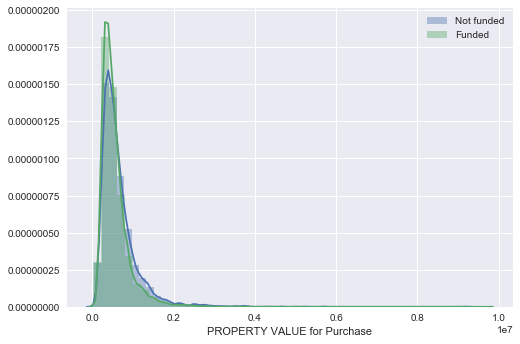

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


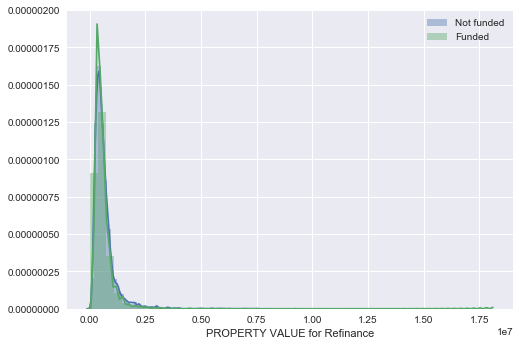

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


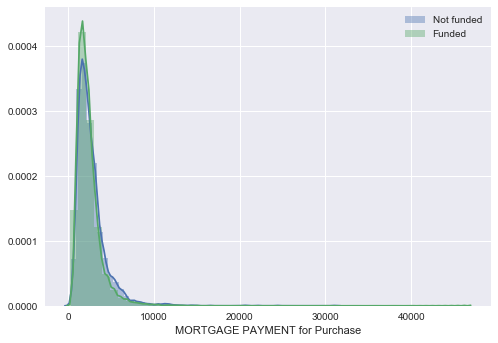

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


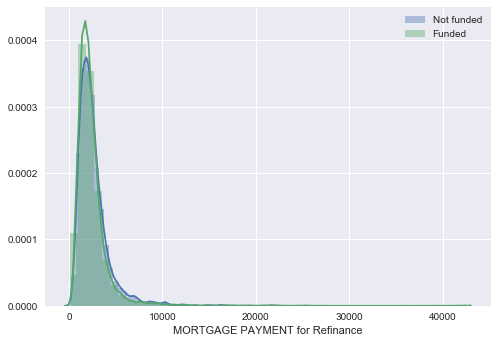

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


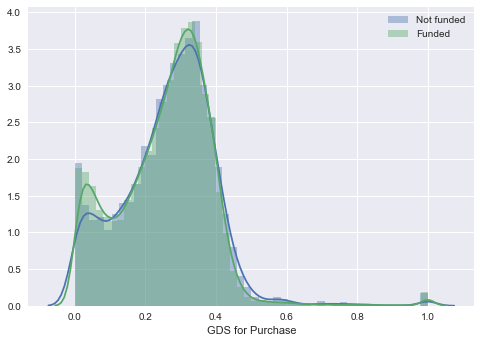

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


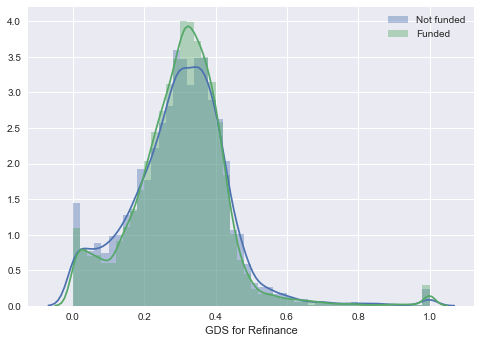

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


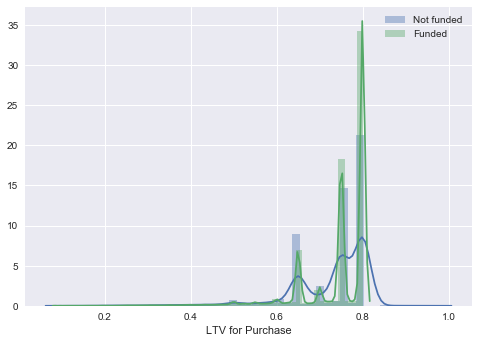

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


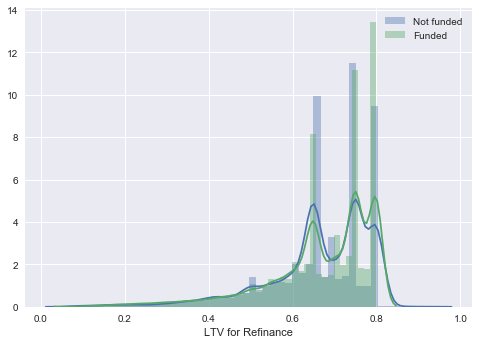

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


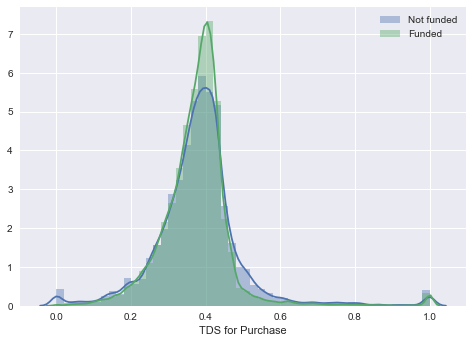

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


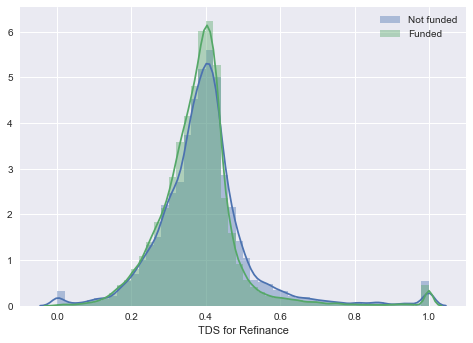

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


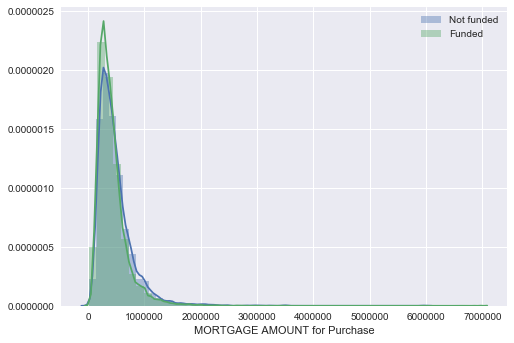

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


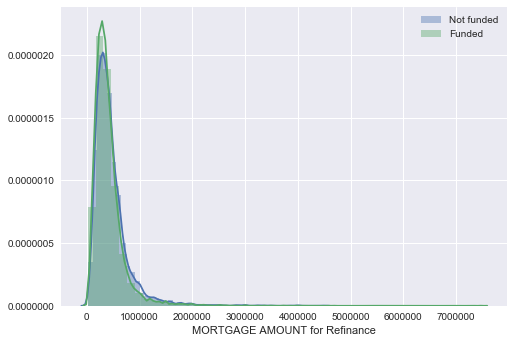

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


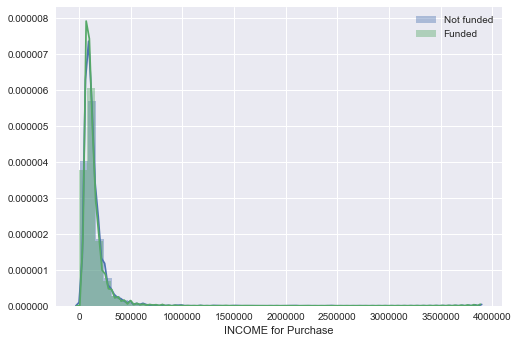

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


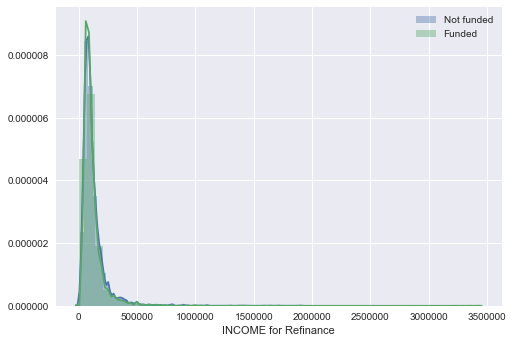

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


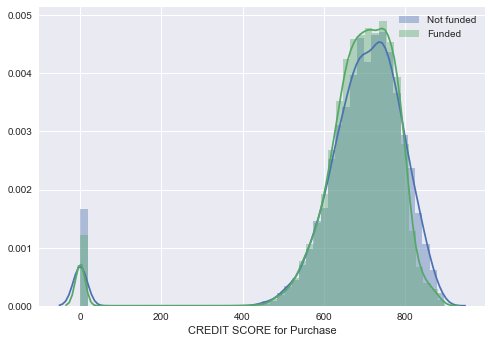

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


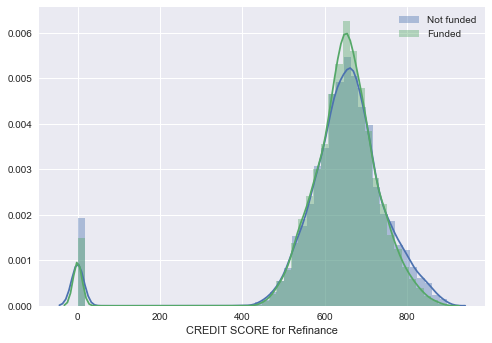

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


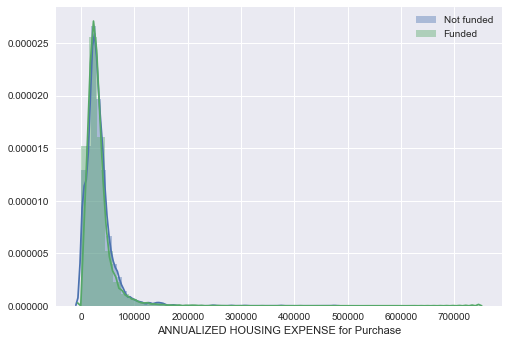

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


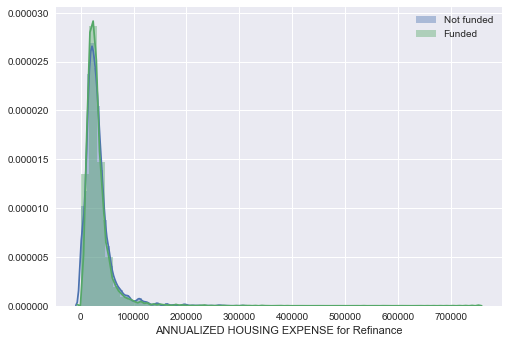

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


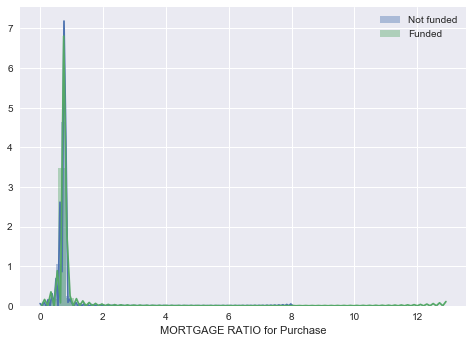

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


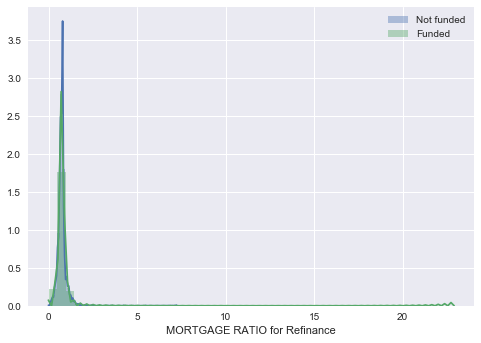

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


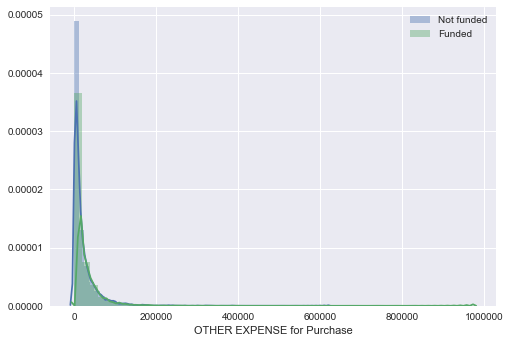

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


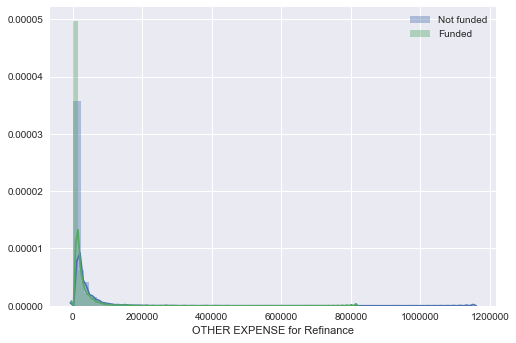

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


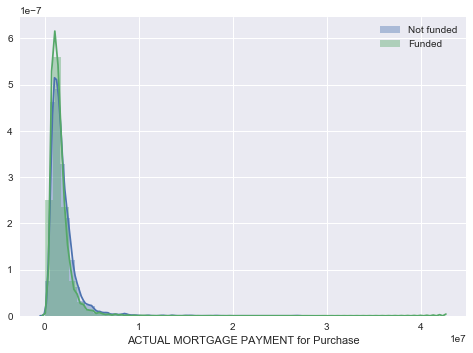

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


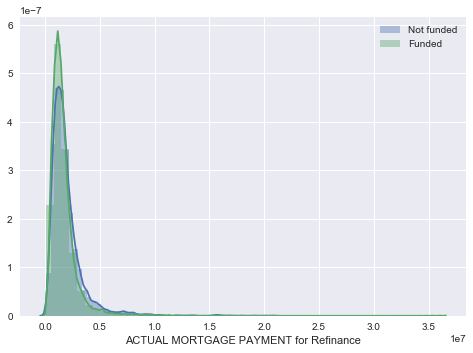

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


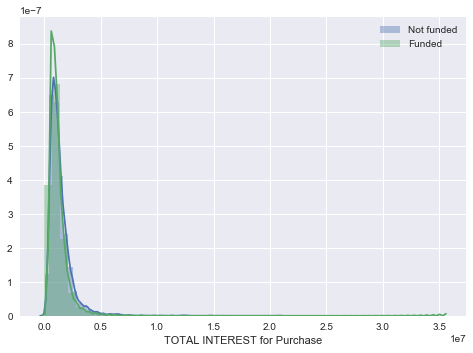

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


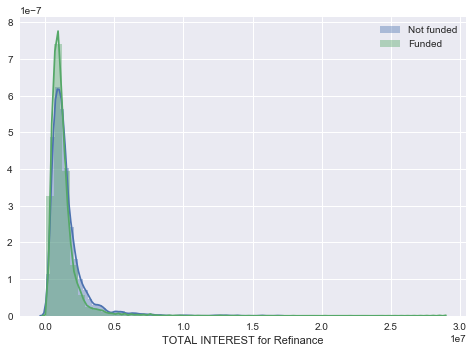

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


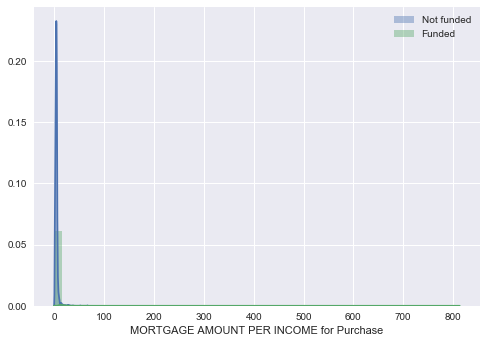

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


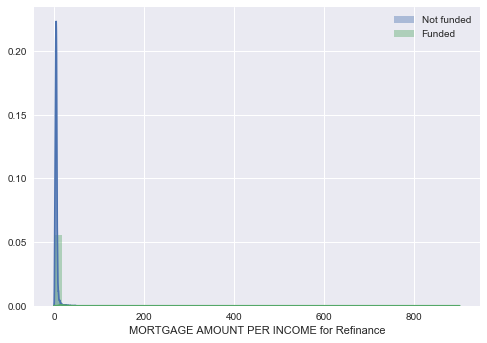

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


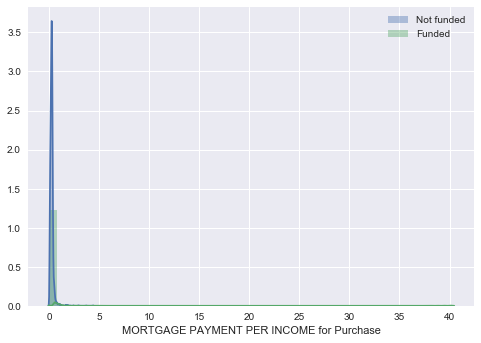

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


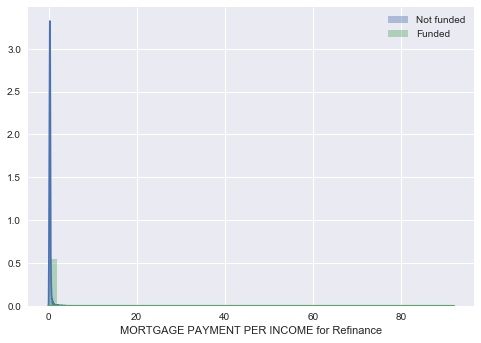

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


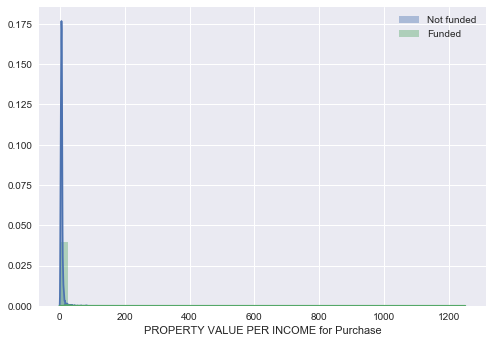

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


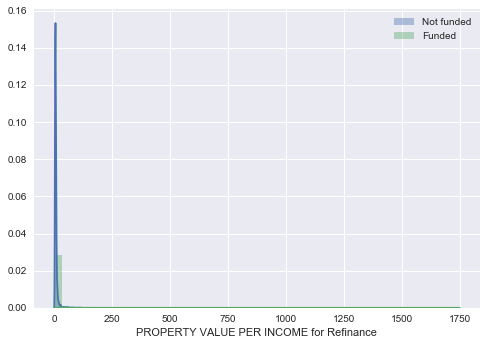

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


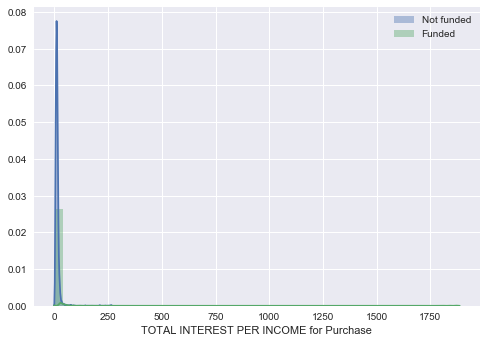

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


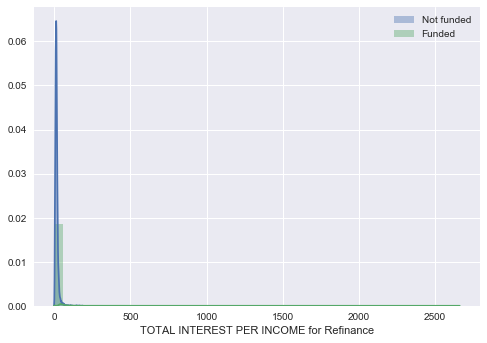

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


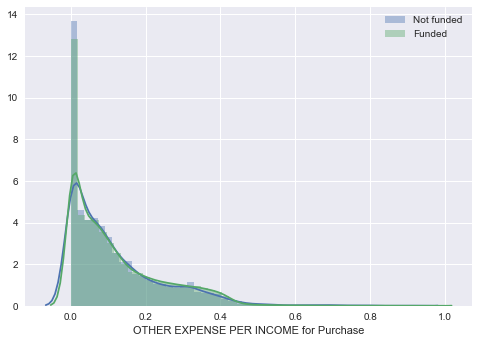

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


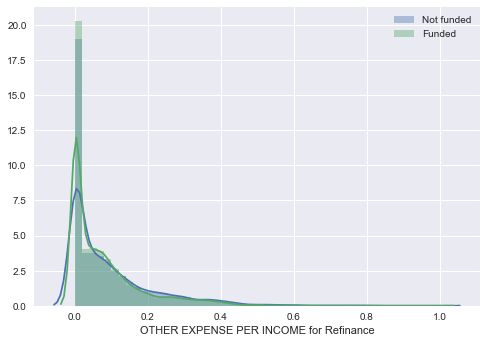

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


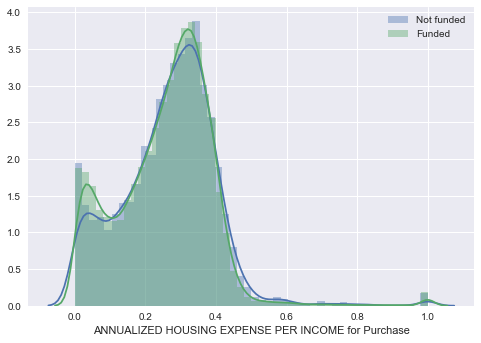

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


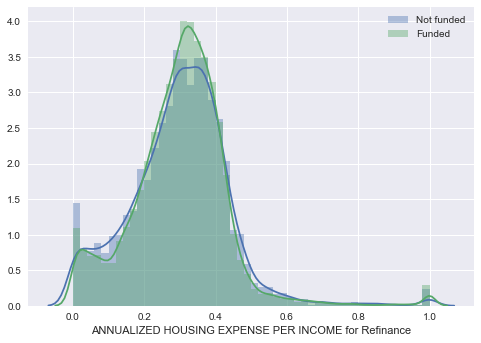

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


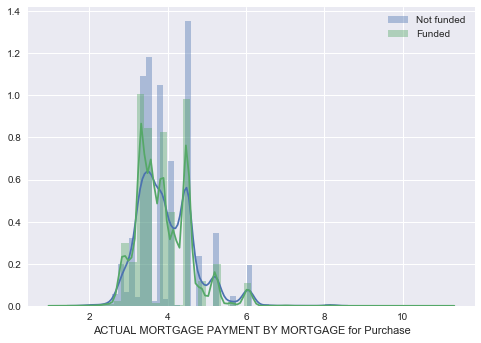

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


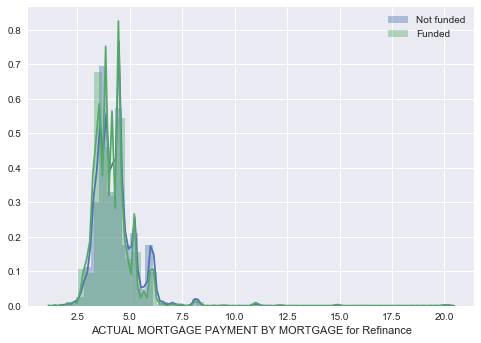

In [33]:
for col in cnt_cols:
    for prop_type in ['Purchase','Refinance']:
        df = data[data['MORTGAGE PURPOSE'] == prop_type]
        sns.distplot(df[df.RESULT == 1][col],kde=True,label='Not funded')
        sns.distplot(df[df.RESULT == 0][col],kde=True,label='Funded')
        plt.xlabel("{} for {}".format(col,prop_type))
        plt.legend()
        plt.show()

In [38]:
from sklearn import manifold
import matplotlib.cm as cm

In [36]:
tsne_model = manifold.TSNE(n_components=2, verbose=1, random_state=0, init='pca')
tsne = tsne_model.fit_transform(data.iloc[:train_len][cnt_cols])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 45642 samples in 0.308s...
[t-SNE] Computed neighbors for 45642 samples in 13.765s...
[t-SNE] Computed conditional probabilities for sample 1000 / 45642
[t-SNE] Computed conditional probabilities for sample 2000 / 45642
[t-SNE] Computed conditional probabilities for sample 3000 / 45642
[t-SNE] Computed conditional probabilities for sample 4000 / 45642
[t-SNE] Computed conditional probabilities for sample 5000 / 45642
[t-SNE] Computed conditional probabilities for sample 6000 / 45642
[t-SNE] Computed conditional probabilities for sample 7000 / 45642
[t-SNE] Computed conditional probabilities for sample 8000 / 45642
[t-SNE] Computed conditional probabilities for sample 9000 / 45642
[t-SNE] Computed conditional probabilities for sample 10000 / 45642
[t-SNE] Computed conditional probabilities for sample 11000 / 45642
[t-SNE] Computed conditional probabilities for sample 12000 / 45642
[t-SNE] Computed conditional probabilities for sa

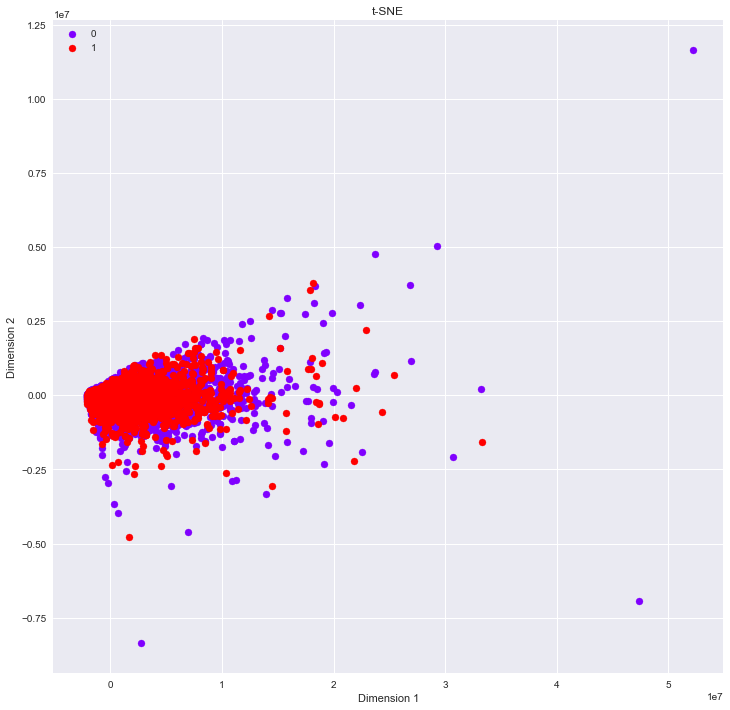

In [39]:
vis_data = pd.DataFrame()
vis_data['x'] = tsne[:,0]
vis_data['y'] = tsne[:,1]
vis_data['RESULT'] = train.RESULT.values

colors = cm.rainbow(np.linspace(0, 1, 2))
plt.figure(figsize=(12,12))

plt.scatter(vis_data[vis_data.RESULT == 0]['x'],vis_data[vis_data.RESULT == 0]['y'],color=colors[0],label=0)
plt.scatter(vis_data[vis_data.RESULT == 1]['x'],vis_data[vis_data.RESULT == 1]['y'],color=colors[1],label=1)


plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE')
plt.legend()
plt.show(block=False)

In [36]:
data2 = data.copy()

In [37]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [121]:
clf = StandardScaler()
data[cnt_cols] = clf.fit_transform(data2[cnt_cols])

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
No handles with labels found to put in legend.


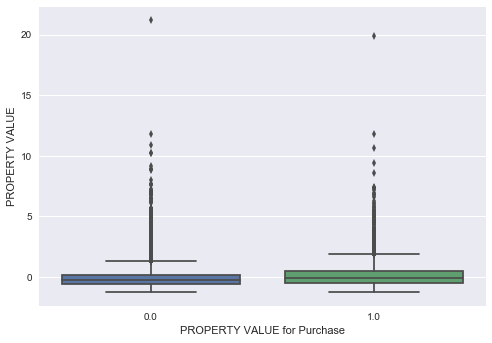

No handles with labels found to put in legend.


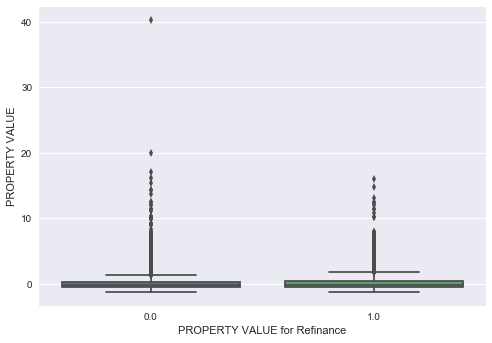

No handles with labels found to put in legend.


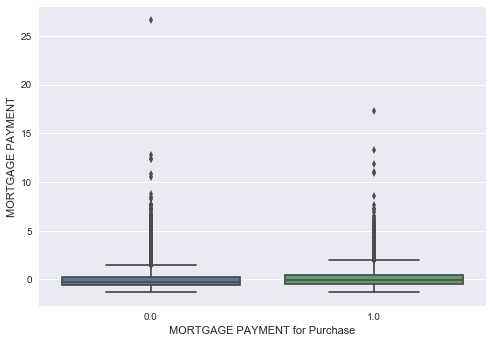

No handles with labels found to put in legend.


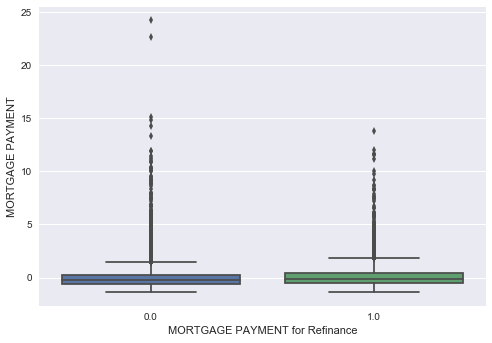

No handles with labels found to put in legend.


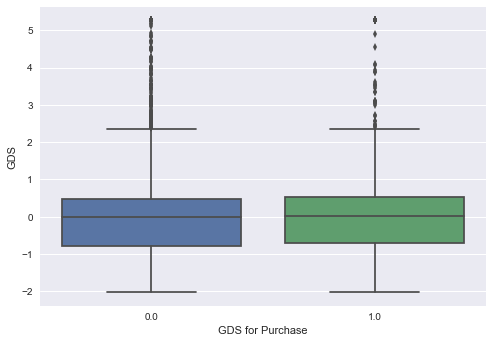

No handles with labels found to put in legend.


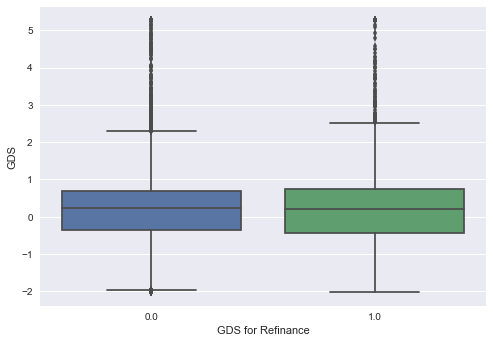

No handles with labels found to put in legend.


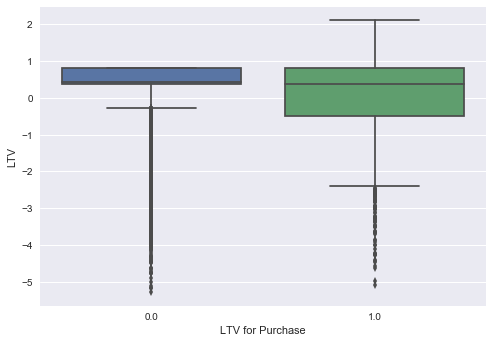

No handles with labels found to put in legend.


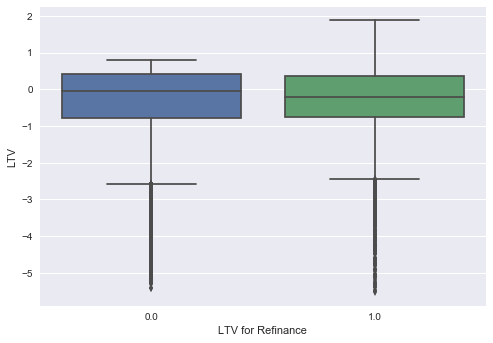

No handles with labels found to put in legend.


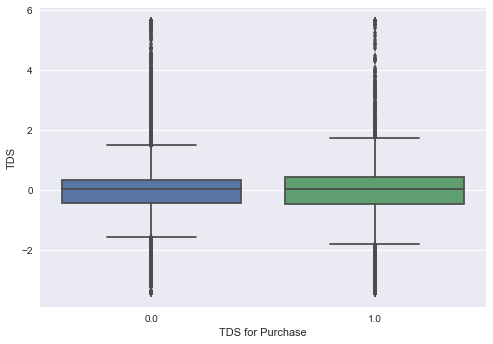

No handles with labels found to put in legend.


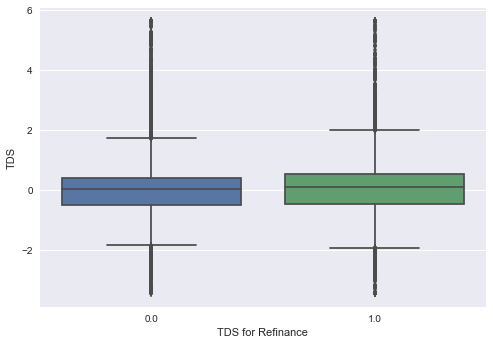

No handles with labels found to put in legend.


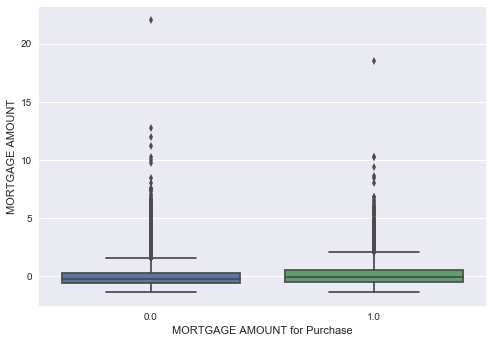

No handles with labels found to put in legend.


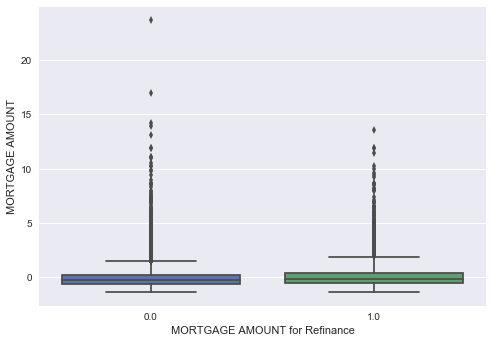

No handles with labels found to put in legend.


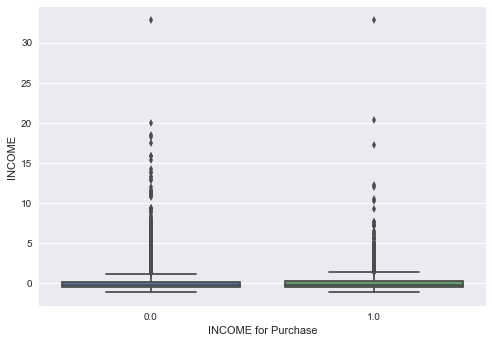

No handles with labels found to put in legend.


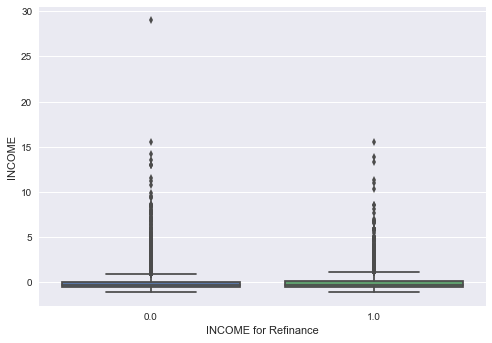

No handles with labels found to put in legend.


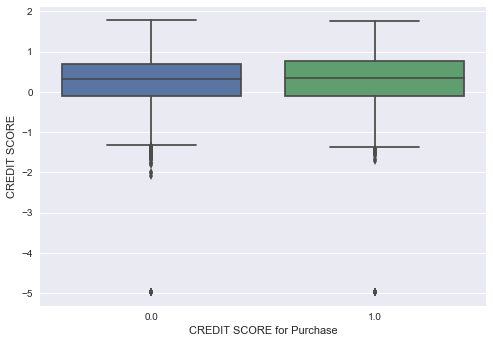

No handles with labels found to put in legend.


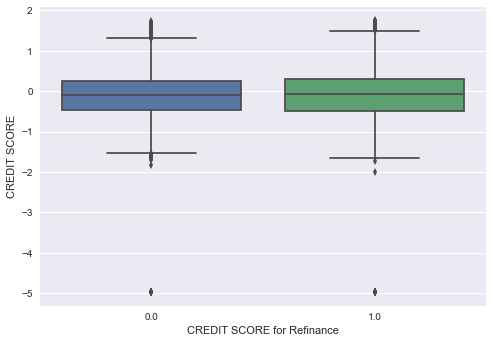

No handles with labels found to put in legend.


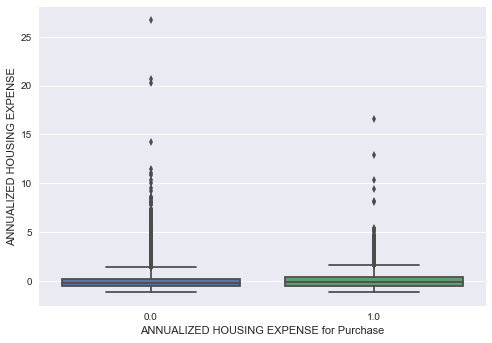

No handles with labels found to put in legend.


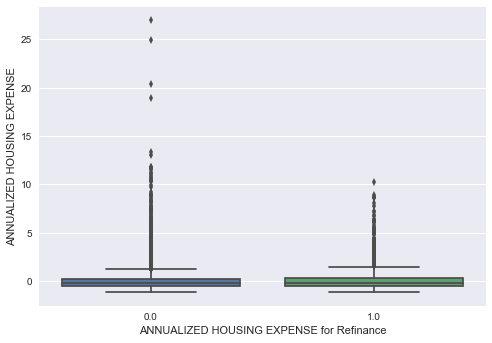

No handles with labels found to put in legend.


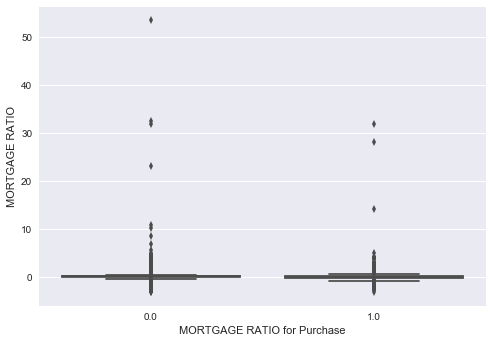

No handles with labels found to put in legend.


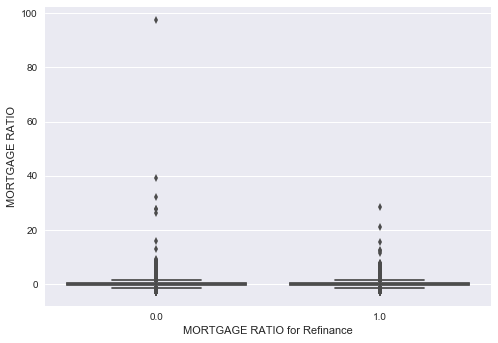

No handles with labels found to put in legend.


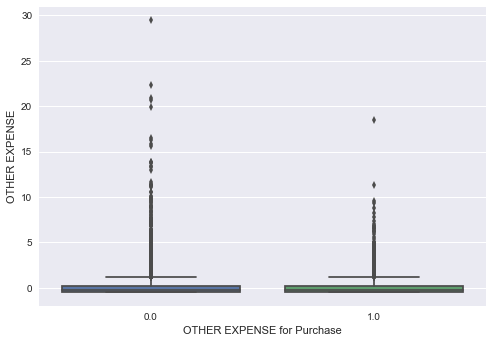

No handles with labels found to put in legend.


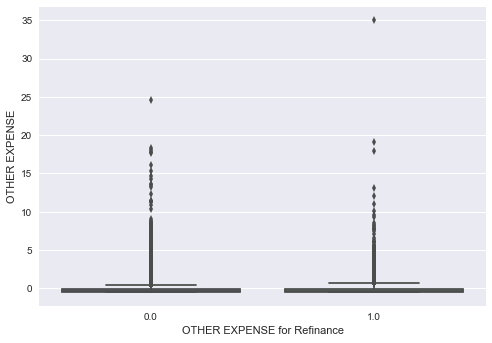

No handles with labels found to put in legend.


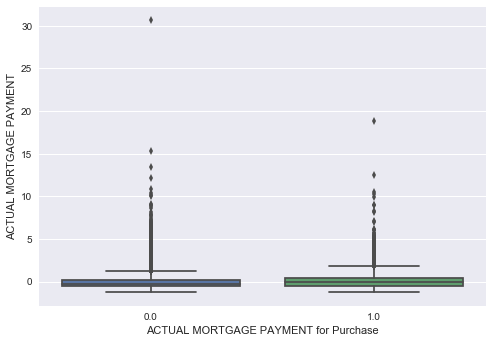

No handles with labels found to put in legend.


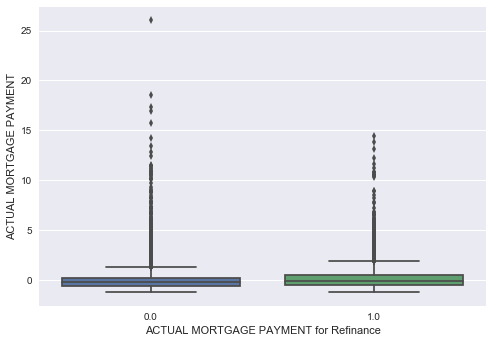

No handles with labels found to put in legend.


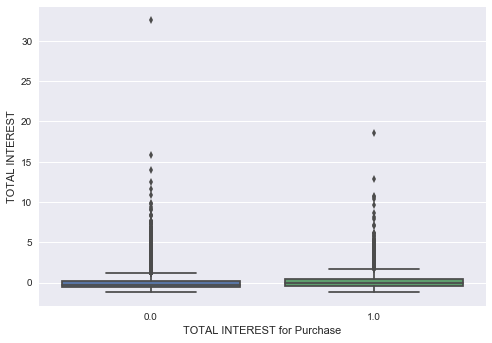

No handles with labels found to put in legend.


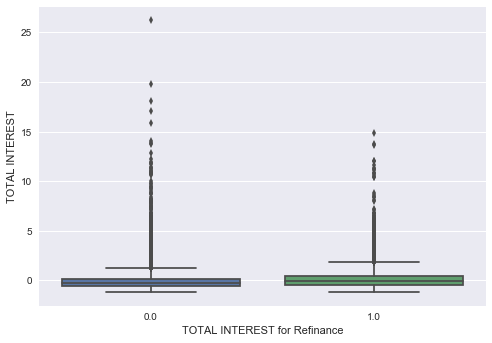

No handles with labels found to put in legend.


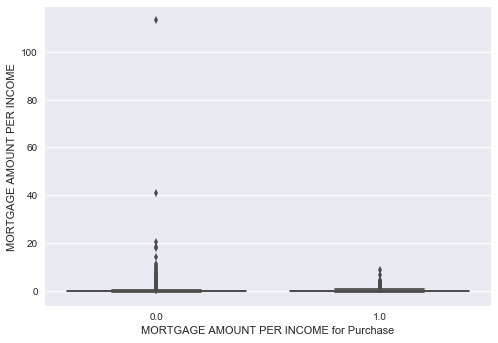

No handles with labels found to put in legend.


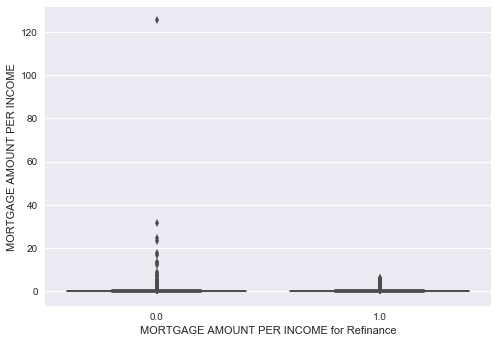

No handles with labels found to put in legend.


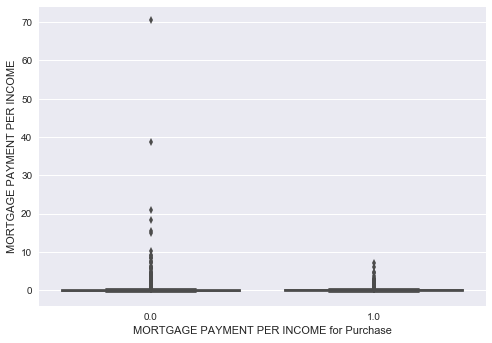

No handles with labels found to put in legend.


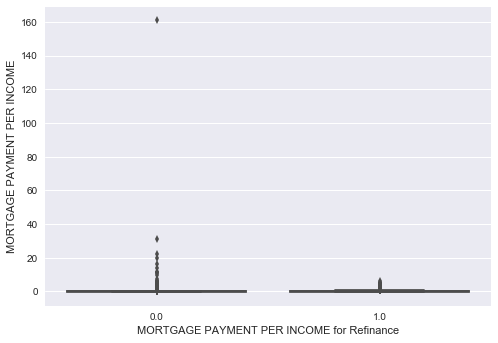

No handles with labels found to put in legend.


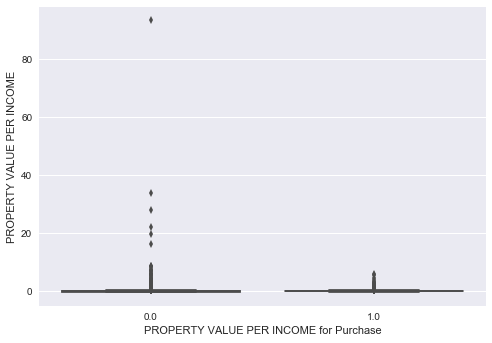

No handles with labels found to put in legend.


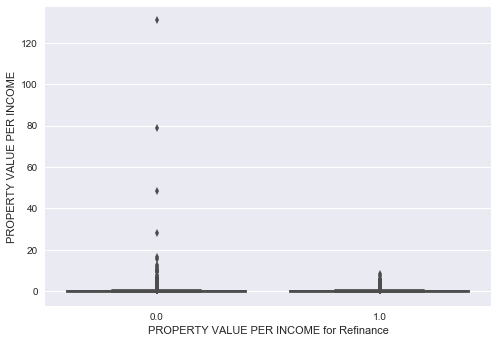

No handles with labels found to put in legend.


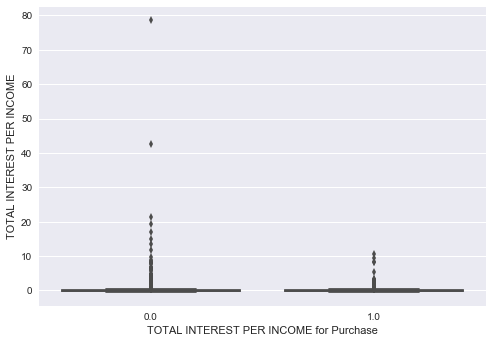

No handles with labels found to put in legend.


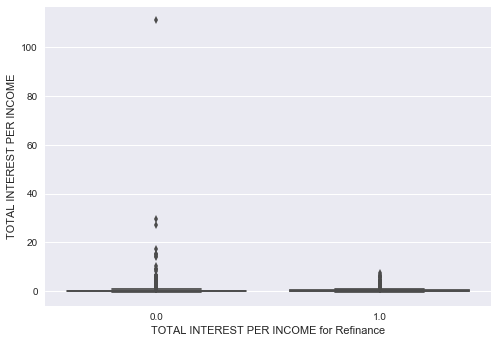

No handles with labels found to put in legend.


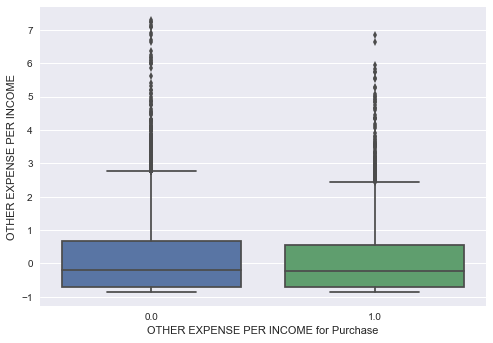

No handles with labels found to put in legend.


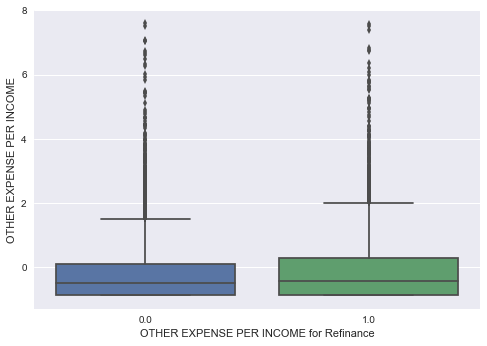

No handles with labels found to put in legend.


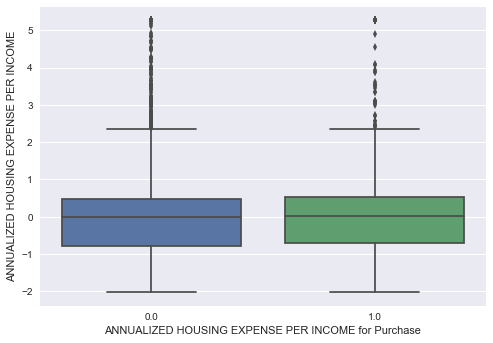

No handles with labels found to put in legend.


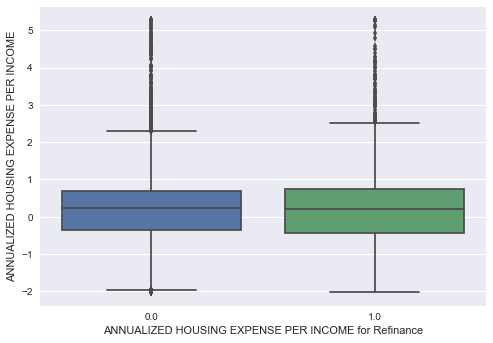

No handles with labels found to put in legend.


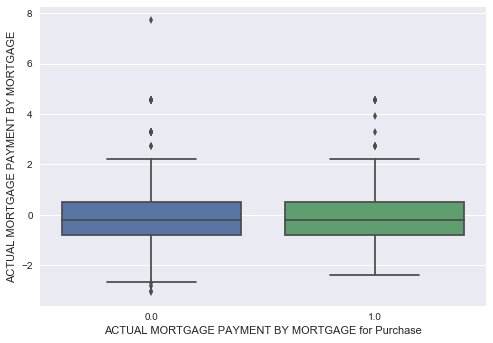

No handles with labels found to put in legend.


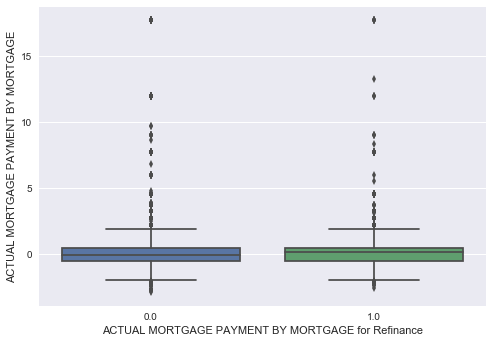

In [122]:
for col in cnt_cols:
    for prop_type in ['Purchase','Refinance']:
        df = data[data['MORTGAGE PURPOSE'] == prop_type]
        sns.boxplot(x='RESULT',y=col,data=df)
        plt.xlabel("{} for {}".format(col,prop_type))
        plt.legend()
        plt.show()

In [40]:
'''
for cat_col in ['AMORTIZATION','MORTGAGE PURPOSE','PAYMENT FREQUENCY','PROPERTY TYPE','TERM','AGE RANGE','GENDER','INCOME TYPE','NAICS CODE','FSA']:
    for cnt_col in ['PROPERTY VALUE','MORTGAGE AMOUNT','MORTGAGE PAYMENT','ANNUALIZED HOUSING EXPENSE','PROPERTY VALUE','OTHER EXPENSE']:
        temp = data.groupby([cat_col])[cnt_col].agg(['mean','max','min','var']).reset_index()
        temp.columns = [cat_col,cnt_col+' ' + cat_col+' MEAN',cnt_col+' ' + cat_col+' MAX',cnt_col+' ' + cat_col+' MIN',cnt_col+' ' + cat_col+' VAR']
        data = pd.merge(data,temp,how='inner')
        data[cnt_col+' ' + cat_col+' Z SCORE'] = data.apply(lambda x: (x[cnt_col]-x[cnt_col+' ' + cat_col+' MEAN'])/np.sqrt(x[cnt_col+' ' + cat_col+' VAR']), axis=1)
        
        temp = data.groupby([cat_col])[cnt_col+ ' PER INCOME'].agg(['mean','max','min','var']).reset_index()
        temp.columns = [cat_col,cnt_col+' ' + cat_col+' PER INCOME MEAN',cnt_col+' ' + cat_col+' PER INCOME MAX',cnt_col+' ' + cat_col+' PER INCOME MIN',cnt_col+' ' + cat_col+' PER INCOME VAR']
        data = pd.merge(data,temp,how='inner')
        data[cnt_col+' ' + cat_col+' PER INCOME MEAN Z SCORE'] = data.apply(lambda x: (x[cnt_col+' PER INCOME']-x[cnt_col+' ' + cat_col+' PER INCOME MEAN'])/np.sqrt(x[cnt_col+' ' + cat_col+' PER INCOME VAR']), axis=1)
        
    for cnt_col in ['INCOME','CREDIT SCORE']:
        temp = data.groupby([cat_col])[cnt_col].agg(['mean','max','min','var']).reset_index()
        temp.columns = [cat_col,cnt_col+' ' + cat_col+' MEAN',cnt_col+' ' + cat_col+' MAX',cnt_col+' ' + cat_col+' MIN',cnt_col+' ' + cat_col+' VAR']
        data = pd.merge(data,temp,how='inner')
        data[cnt_col+' ' + cat_col+' Z SCORE'] = data.apply(lambda x: (x[cnt_col]-x[cnt_col+' ' + cat_col+' MEAN'])/np.sqrt(x[cnt_col+' ' + cat_col+' VAR']), axis=1)
        
'''

"\nfor cat_col in ['AMORTIZATION','MORTGAGE PURPOSE','PAYMENT FREQUENCY','PROPERTY TYPE','TERM','AGE RANGE','GENDER','INCOME TYPE','NAICS CODE','FSA']:\n    for cnt_col in ['PROPERTY VALUE','MORTGAGE AMOUNT','MORTGAGE PAYMENT','ANNUALIZED HOUSING EXPENSE','PROPERTY VALUE','OTHER EXPENSE']:\n        temp = data.groupby([cat_col])[cnt_col].agg(['mean','max','min','var']).reset_index()\n        temp.columns = [cat_col,cnt_col+' ' + cat_col+' MEAN',cnt_col+' ' + cat_col+' MAX',cnt_col+' ' + cat_col+' MIN',cnt_col+' ' + cat_col+' VAR']\n        data = pd.merge(data,temp,how='inner')\n        data[cnt_col+' ' + cat_col+' Z SCORE'] = data.apply(lambda x: (x[cnt_col]-x[cnt_col+' ' + cat_col+' MEAN'])/np.sqrt(x[cnt_col+' ' + cat_col+' VAR']), axis=1)\n        \n        temp = data.groupby([cat_col])[cnt_col+ ' PER INCOME'].agg(['mean','max','min','var']).reset_index()\n        temp.columns = [cat_col,cnt_col+' ' + cat_col+' PER INCOME MEAN',cnt_col+' ' + cat_col+' PER INCOME MAX',cnt_col+' ' + 

Target encoding script - https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features

In [177]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [178]:
trn, sub = target_encode(train["FSA"], 
                         test["FSA"], 
                         target=train.RESULT, 
                         min_samples_leaf=10,
                         smoothing=10,
                         noise_level=0.01)
data['FSA'] = pd.concat([trn,sub],axis=0).values

In [179]:
data = pd.get_dummies(data,columns=['AMORTIZATION','MORTGAGE PURPOSE','PAYMENT FREQUENCY','PROPERTY TYPE','TERM','AGE RANGE','GENDER','INCOME TYPE','NAICS CODE'])

In [160]:
data.to_csv('../data/data_full.csv',index=False)

In [180]:
data.head(3)

,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,MORTGAGE AMOUNT,RATE,FSA,INCOME,CREDIT SCORE,RESULT,ANNUALIZED HOUSING EXPENSE,OTHER EXPENSE,TOTAL INTEREST,MORTGAGE AMOUNT PER INCOME,MORTGAGE PAYMENT PER INCOME,PROPERTY VALUE PER INCOME,TOTAL INTEREST PER INCOME,OTHER EXPENSE PER INCOME,ANNUALIZED HOUSING EXPENSE PER INCOME,AMORTIZATION_60,AMORTIZATION_120,AMORTIZATION_180,AMORTIZATION_240,AMORTIZATION_300,AMORTIZATION_360,AMORTIZATION_420,AMORTIZATION_480,MORTGAGE PURPOSE_Purchase,MORTGAGE PURPOSE_Refinance,PAYMENT FREQUENCY_Bi-Weekly,PAYMENT FREQUENCY_Bi-Weekly Accelerated,PAYMENT FREQUENCY_Monthly,PAYMENT FREQUENCY_Semi-Monthly,PAYMENT FREQUENCY_Weekly,PAYMENT FREQUENCY_Weekly Accelerated,PROPERTY TYPE_Duplex,PROPERTY TYPE_Fourplex,PROPERTY TYPE_High Rise,PROPERTY TYPE_Semi-Detached,PROPERTY TYPE_Single Detached,PROPERTY TYPE_Townhouse Condominium,PROPERTY TYPE_Townhouse Freehold,PROPERTY TYPE_Triplex,TERM_6,TERM_12,TERM_24,TERM_36,TERM_48,TERM_60,AGE RANGE_25-29,AGE RANGE_30-34,AGE RANGE_35-39,AGE RANGE_40-44,AGE RANGE_45-49,AGE RANGE_50-54,AGE RANGE_55-59,AGE RANGE_60-64,AGE RANGE_65-69,AGE RANGE_70 and over,AGE RANGE_Under 25,GENDER_Female,GENDER_Male,GENDER_Unknown,INCOME TYPE_-1,INCOME TYPE_1,INCOME TYPE_2,INCOME TYPE_3,INCOME TYPE_4,INCOME TYPE_5,INCOME TYPE_6,INCOME TYPE_7,INCOME TYPE_8,INCOME TYPE_9,INCOME TYPE_10,INCOME TYPE_11,INCOME TYPE_12,INCOME TYPE_13,INCOME TYPE_14,INCOME TYPE_15,INCOME TYPE_16,INCOME TYPE_17,INCOME TYPE_18,INCOME TYPE_19,INCOME TYPE_20,NAICS CODE_11,NAICS CODE_22,NAICS CODE_23,NAICS CODE_31-33,NAICS CODE_42,NAICS CODE_44-45,NAICS CODE_48-49,NAICS CODE_51,NAICS CODE_52,NAICS CODE_53,NAICS CODE_54,NAICS CODE_55,NAICS CODE_56,NAICS CODE_61,NAICS CODE_62,NAICS CODE_71,NAICS CODE_72,NAICS CODE_81,NAICS CODE_92
0,1.600000e+06,5429,0.6198,0.6500,0.7163,1040000.0,0.040,0.848996,108000,681,1.0,66938.4,10422.0,1.537263e+06,9.629630,0.050269,14.814815,14.233917,0.0965,0.6198,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5.249697e+05,2179,0.3522,0.7429,0.4065,390000.0,0.045,0.826004,78000,710,1.0,27471.6,4235.4,5.018697e+05,5.000000,0.027936,6.730381,6.434227,0.0543,0.3522,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,5.310000e+05,2152,0.3097,0.8000,0.3541,424800.0,0.035,0.773125,87000,709,1.0,26943.9,3862.8,5.217883e+05,4.882759,0.024736,6.103448,5.997567,0.0444,0.3097,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [41]:
for col in data.columns:
    if data[col].nunique() == 1:
        print (col)

In [123]:
train = data.iloc[:train_len]
test = data.iloc[train_len:]

In [185]:
?scipy.stats.chi2_contingency

In [184]:
scipy.stats.chi2_contingency(pd.crosstab(train[col],train.RESULT))

(0.018525624147814786,
 0.891735216542092,
 1,
 array([[9.61857850e+03, 3.60214215e+04],
        [4.21497743e-01, 1.57850226e+00]]))

In [187]:
train_cols = []
for col in data.columns:
    if col != 'RESULT':
        if data[col].nunique() == 2:
            p_value = scipy.stats.chi2_contingency(pd.crosstab(train[col],train.RESULT))[1]
        else:
            d1 = train[train.RESULT == 1][col]
            d2 = train[train.RESULT == 0][col]
            p_value = scipy.stats.ttest_ind(d1,d2).pvalue

        if p_value < .05:
            print (col)
            train_cols.append(col)

PROPERTY VALUE
MORTGAGE PAYMENT
LTV
MORTGAGE AMOUNT
RATE
FSA
INCOME
CREDIT SCORE
TOTAL INTEREST
MORTGAGE AMOUNT PER INCOME
MORTGAGE PAYMENT PER INCOME
PROPERTY VALUE PER INCOME
TOTAL INTEREST PER INCOME
AMORTIZATION_240
AMORTIZATION_300
AMORTIZATION_360
AMORTIZATION_420
MORTGAGE PURPOSE_Purchase
MORTGAGE PURPOSE_Refinance
PAYMENT FREQUENCY_Bi-Weekly
PAYMENT FREQUENCY_Bi-Weekly Accelerated
PAYMENT FREQUENCY_Monthly
PROPERTY TYPE_Duplex
PROPERTY TYPE_Fourplex
PROPERTY TYPE_High Rise
PROPERTY TYPE_Semi-Detached
PROPERTY TYPE_Single Detached
PROPERTY TYPE_Townhouse Condominium
PROPERTY TYPE_Townhouse Freehold
PROPERTY TYPE_Triplex
TERM_6
TERM_12
TERM_24
TERM_36
TERM_60
AGE RANGE_30-34
AGE RANGE_50-54
AGE RANGE_55-59
AGE RANGE_Under 25
GENDER_Male
GENDER_Unknown
INCOME TYPE_1
INCOME TYPE_2
INCOME TYPE_3
INCOME TYPE_5
INCOME TYPE_6
INCOME TYPE_12
INCOME TYPE_17
NAICS CODE_23
NAICS CODE_44-45
NAICS CODE_53
NAICS CODE_55
NAICS CODE_72
NAICS CODE_81
NAICS CODE_92


55

In [148]:
train = data.iloc[:train_len]
test = data.iloc[train_len:]

In [56]:
print (train.shape, test.shape)

(45642, 703) (15214, 703)


In [142]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, BaseEnsemble, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import eli5
import shap
from sklearn import model_selection

In [48]:
kf = KFold(n_splits=5,random_state=123,shuffle=True)
train = train.sample(frac=1)
for train_index, test_index in kf.split(train):
    break

In [53]:
learning_rate = 0.1
feature_fraction = 1
num_boost_round = 1000
params = {"objective": "binary",
          "boosting_type": "gbdt",
          "learning_rate": learning_rate,
          "feature_fraction": feature_fraction,
          "verbosity": 0,
          "is_unbalance": True
          }

In [54]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

In [47]:
'''
for train_index, test_index in kf.split(train):
    train_data = lgb.Dataset(train.iloc[train_index].values, label=target.iloc[train_index].values.astype(int), 
                         feature_name=list(train.columns))
    test_data = lgb.Dataset(train.iloc[test_index].values, label=target.iloc[test_index].values.astype(int), 
                        feature_name=list(train.columns), reference=train_data)
    lgb_model = lgb.train(params, train_data, 
                      num_boost_round=num_boost_round, 
                      valid_sets=(test_data,),  
                      verbose_eval=100)
'''

'\nfor train_index, test_index in kf.split(train):\n    train_data = lgb.Dataset(train.iloc[train_index].values, label=target.iloc[train_index].values.astype(int), \n                         feature_name=list(train.columns))\n    test_data = lgb.Dataset(train.iloc[test_index].values, label=target.iloc[test_index].values.astype(int), \n                        feature_name=list(train.columns), reference=train_data)\n    lgb_model = lgb.train(params, train_data, \n                      num_boost_round=num_boost_round, \n                      valid_sets=(test_data,),  \n                      verbose_eval=100)\n'

In [51]:
?lgb.train

In [55]:
train_data = lgb.Dataset(train.iloc[train_index][cnt_cols], label=train.RESULT.iloc[train_index].values.astype(int), 
                         feature_name=cnt_cols)
test_data = lgb.Dataset(train.iloc[test_index][cnt_cols], label=train.RESULT.iloc[test_index].values.astype(int), 
                    feature_name=cnt_cols, reference=train_data)
lgb_model = lgb.train(params, train_data, 
                  num_boost_round=10000, 
                  valid_sets=(test_data,),  
                  verbose_eval=100,feval=lgb_f1_score,early_stopping_rounds=200)

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 200 rounds.


C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[100]	valid_0's binary_logloss: 0.633797	valid_0's f1: 0.376783
[200]	valid_0's binary_logloss: 0.619347	valid_0's f1: 0.370572
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.50861	valid_0's f1: 0


In [86]:
cat_cols = []
cnt_cols = []
for col in list(train.columns):
    if train[col].nunique() == 2:
        cat_cols.append(col)
    else:
        cnt_cols.append(col)

In [87]:
print (len(cat_cols),len(cnt_cols))

132 571


In [108]:
corr_matrix = train.corr().abs()
high_corr_var=np.where(corr_matrix>0.9)
high_corr_var=[(corr_matrix.columns[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
print (len(high_corr_var))

4738


In [109]:
cols_to_remove = list(set(i[0] for i in high_corr_var))
train_cols = list(set(list(train.columns)) - set(cols_to_remove))
print ("Number of final training columns is {}".format(len(train_cols)))

Number of final training columns is 240


In [110]:
import scipy

In [120]:
for col in train_cols:
    if train[col].nunique() == 1 or test[col].nunique() == 1:
        print (col)
        train_cols.remove(col)

INCOME TYPE_20
PAYMENT FREQUENCY_Semi-Monthly
AMORTIZATION_480
CREDIT SCORE PROPERTY TYPE MIN
INCOME MORTGAGE PURPOSE MIN
CREDIT SCORE MORTGAGE PURPOSE MIN
CREDIT SCORE AGE RANGE MIN
PAYMENT FREQUENCY_Weekly Accelerated
INCOME TYPE_13
CREDIT SCORE NAICS CODE MIN
CREDIT SCORE MORTGAGE PURPOSE MAX
INCOME GENDER MIN


In [140]:
for col in train_cols:
    if data[col].isnull().any() == True:
        print (col)
        train_cols.remove(col)

MORTGAGE PAYMENT FSA PER INCOME VAR
CREDIT SCORE FSA Z SCORE
MORTGAGE PAYMENT FSA PER INCOME MEAN Z SCORE
OTHER EXPENSE FSA PER INCOME MEAN Z SCORE


In [131]:
for col in train_cols:
    d1 = train[target == 1][col]
    d2 = train[target == 0][col]
    if train[col].nunique() > 2:
        p_value = scipy.stats.ttest_ind(d1,d2).pvalue
        #F = np.var(data[target])/np.var(data[col])
        #df1 = len(data) - 1
        #p_value = scipy.stats.f.cdf(F, df1, df1)

        if p_value > .1:
            train_cols.remove(col)
#cols_selected = list(set(cols_selected) - set(cols_to_remove))
print (len(train_cols))

147


In [132]:
train_cols

['MORTGAGE PAYMENT FSA PER INCOME MAX',
 'INCOME NAICS CODE VAR',
 'INCOME TYPE_1',
 'NAICS CODE_53',
 'INCOME TYPE_14',
 'RATE',
 'INCOME TYPE_6',
 'GENDER_Unknown',
 'AGE RANGE_30-34',
 'MORTGAGE PAYMENT AGE RANGE PER INCOME MIN',
 'CREDIT SCORE PAYMENT FREQUENCY MAX',
 'NAICS CODE_71',
 'MORTGAGE PAYMENT FSA PER INCOME VAR',
 'CREDIT SCORE PAYMENT FREQUENCY MEAN',
 'ANNUALIZED HOUSING EXPENSE AGE RANGE Z SCORE',
 'MORTGAGE AMOUNT AGE RANGE PER INCOME VAR',
 'NAICS CODE_56',
 'INCOME PAYMENT FREQUENCY MIN',
 'AMORTIZATION_240',
 'CREDIT SCORE FSA Z SCORE',
 'ANNUALIZED HOUSING EXPENSE AGE RANGE PER INCOME MAX',
 'INCOME INCOME TYPE MIN',
 'AGE RANGE_25-29',
 'AMORTIZATION_420',
 'MORTGAGE PAYMENT PROPERTY TYPE PER INCOME MIN',
 'MORTGAGE PAYMENT AGE RANGE VAR',
 'GENDER_Male',
 'NAICS CODE_51',
 'MORTGAGE PAYMENT NAICS CODE PER INCOME MIN',
 'TERM_60',
 'AGE RANGE_45-49',
 'NAICS CODE_54',
 'AGE RANGE_70 and over',
 'CREDIT SCORE NAICS CODE MAX',
 'NAICS CODE_22',
 'INCOME TYPE_15',
 'PROPERTY TYPE_Townhouse Condominium',
 'NAICS CODE_81',
 'PROPERTY VALUE AGE RANGE MEAN',
 'AMORTIZATION_360',
 'CREDIT SCORE AGE RANGE MEAN',
 'CREDIT SCORE NAICS CODE VAR',
 'MORTGAGE PAYMENT AGE RANGE MAX',
 'INCOME TYPE_7',
 'ANNUALIZED HOUSING EXPENSE NAICS CODE PER INCOME MIN',
 'TERM_24',
 'ANNUALIZED HOUSING EXPENSE NAICS CODE PER INCOME MEAN',
 'CREDIT SCORE GENDER MIN',
 'MORTGAGE AMOUNT FSA PER INCOME MIN',
 'AGE RANGE_55-59',
 'INCOME TYPE_11',
 'INCOME TYPE_12',
 'OTHER EXPENSE NAICS CODE PER INCOME VAR',
 'AGE RANGE_35-39',
 'PROPERTY TYPE_High Rise',
 'INCOME TYPE_8',
 'ANNUALIZED HOUSING EXPENSE PROPERTY TYPE Z SCORE',
 'OTHER EXPENSE NAICS CODE PER INCOME MIN',
 'MORTGAGE PAYMENT FSA PER INCOME MIN',
 'INCOME TYPE_3',
 'NAICS CODE_23',
 'CREDIT SCORE INCOME TYPE MIN',
 'MORTGAGE PAYMENT FSA PER INCOME MEAN Z SCORE',
 'GENDER_Female',
 'PROPERTY TYPE_Townhouse Freehold',
 'MORTGAGE AMOUNT AGE RANGE MIN',
 'OTHER EXPENSE INCOME TYPE PER INCOME MIN',
 'CREDIT SCORE AMORTIZATION VAR',
 'MORTGAGE PAYMENT PROPERTY TYPE MIN',
 'MORTGAGE PAYMENT NAICS CODE VAR',
 'INCOME TYPE_-1',
 'LTV',
 'NAICS CODE_92',
 'NAICS CODE_31-33',
 'MORTGAGE PURPOSE_Refinance',
 'ANNUALIZED HOUSING EXPENSE NAICS CODE PER INCOME MEAN Z SCORE',
 'TERM_6',
 'NAICS CODE_61',
 'INCOME AGE RANGE VAR',
 'MORTGAGE PAYMENT NAICS CODE MAX',
 'CREDIT SCORE INCOME TYPE MAX',
 'OTHER EXPENSE AGE RANGE PER INCOME MIN',
 'TERM_48',
 'MORTGAGE PAYMENT INCOME TYPE MIN',
 'OTHER EXPENSE NAICS CODE PER INCOME MEAN Z SCORE',
 'AGE RANGE_60-64',
 'AMORTIZATION_60',
 'INCOME AMORTIZATION VAR',
 'NAICS CODE_11',
 'MORTGAGE PAYMENT NAICS CODE PER INCOME MEAN',
 'INCOME FSA MAX',
 'AGE RANGE_40-44',
 'ANNUALIZED HOUSING EXPENSE FSA MIN',
 'CREDIT SCORE INCOME TYPE VAR',
 'NAICS CODE_52',
 'INCOME TYPE_17',
 'PROPERTY TYPE_Fourplex',
 'ANNUALIZED HOUSING EXPENSE INCOME TYPE PER INCOME MEAN Z SCORE',
 'PROPERTY TYPE_Single Detached',
 'INCOME TYPE_4',
 'FSA',
 'CREDIT SCORE NAICS CODE MEAN',
 'TERM_12',
 'INCOME TYPE_19',
 'NAICS CODE_48-49',
 'INCOME TYPE_18',
 'INCOME TYPE_5',
 'OTHER EXPENSE PAYMENT FREQUENCY Z SCORE',
 'NAICS CODE_55',
 'AMORTIZATION_120',
 'AGE RANGE_50-54',
 'AMORTIZATION_180',
 'PAYMENT FREQUENCY_Monthly',
 'INCOME INCOME TYPE Z SCORE',
 'MORTGAGE PAYMENT INCOME TYPE PER INCOME MEAN',
 'INCOME TYPE_9',
 'OTHER EXPENSE AGE RANGE Z SCORE',
 'INCOME TYPE_16',
 'OTHER EXPENSE FSA PER INCOME MEAN Z SCORE',
 'ANNUALIZED HOUSING EXPENSE GENDER PER INCOME MEAN Z SCORE',
 'MORTGAGE PAYMENT NAICS CODE MIN',
 'AGE RANGE_Under 25',
 'ANNUALIZED HOUSING EXPENSE NAICS CODE Z SCORE',
 'PROPERTY VALUE FSA MIN',
 'NAICS CODE_44-45',
 'PROPERTY TYPE_Semi-Detached',
 'PROPERTY TYPE_Duplex',
 'AGE RANGE_65-69',
 'INCOME FSA MEAN',
 'MORTGAGE PAYMENT AMORTIZATION PER INCOME MEAN',
 'PAYMENT FREQUENCY_Bi-Weekly Accelerated',
 'NAICS CODE_62',
 'ANNUALIZED HOUSING EXPENSE NAICS CODE PER INCOME VAR',
 'TERM_36',
 'NAICS CODE_72',
 'INCOME AGE RANGE MAX',
 'PROPERTY VALUE NAICS CODE 

In [75]:
#train['RESULT'] = target.values


In [119]:
rf = RandomForestClassifier(n_estimators=500,class_weight={0:.2,1:.8})
rf.fit(train[cnt_cols].iloc[train_index], train.RESULT.iloc[train_index])
pred = rf.predict(train[cnt_cols].iloc[test_index])

In [120]:
print (accuracy_score(train.RESULT.iloc[test_index],pred))
print (confusion_matrix(train.RESULT.iloc[test_index],pred))
print (f1_score(train.RESULT.iloc[test_index],pred))

0.7923102201774564
[[7174   65]
 [1831   59]]
0.05858987090367427


In [124]:
train2 = pd.concat([train[train.RESULT == 0].sample(frac=.3),train[train.RESULT == 1]],axis=0).sample(frac=1)

In [125]:
for train_index2, test_index2 in kf.split(train2):
    break

In [152]:
rf = RandomForestClassifier(n_estimators=500)
rf.fit(train2[cnt_cols].iloc[train_index2], train2.RESULT.iloc[train_index2])
pred = rf.predict(train2[cnt_cols].iloc[test_index2])

In [153]:
print (accuracy_score(train2.RESULT.iloc[test_index2],pred))
print (confusion_matrix(train2.RESULT.iloc[test_index2],pred))
print (f1_score(train2.RESULT.iloc[test_index2],pred))

0.6054821341164953
[[1479  658]
 [ 954  995]]
0.5524708495280399


In [155]:
testpred = rf.predict(test[cnt_cols])
submission1 = pd.read_csv('../data/CAX_MortgageModeling_SubmissionFormat.csv')
submission1.Result_Predicted = testpred
submission1.Result_Predicted = submission1.Result_Predicted.apply(lambda x: "FUNDED" if x == 0 else "NOT FUNDED")
print (submission1.Result_Predicted.value_counts(normalize=True))
submission1.to_csv('../submissions/submission2.csv',index=False)

FUNDED        0.649993
NOT FUNDED    0.350007
Name: Result_Predicted, dtype: float64


In [161]:
from tpot import TPOTClassifier

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\deap\tools\_hypervolume\pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


In [162]:
tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2)

In [163]:
tpot.fit(train2[cnt_cols].iloc[train_index2], train2.RESULT.iloc[train_index2])
print(tpot.score(train2[cnt_cols].iloc[test_index2], train2.RESULT.iloc[test_index2]))

Generation 1 - Current best internal CV score: 0.6026315789473683
Generation 2 - Current best internal CV score: 0.6026315789473683
Generation 3 - Current best internal CV score: 0.6026315789473683
Generation 4 - Current best internal CV score: 0.6083231334149327
Generation 5 - Current best internal CV score: 0.6083231334149327

Best pipeline: RandomForestClassifier(PCA(input_matrix, iterated_power=10, svd_solver=randomized), bootstrap=True, criterion=entropy, max_features=0.8, min_samples_leaf=12, min_samples_split=9, n_estimators=100)
0.6106216348507097


In [164]:
tpot.export('tpot_pipeline1.py')

In [112]:
train2['MORTGAGE PURPOSE'].value_counts()

Refinance    10235
Purchase     10191
Name: MORTGAGE PURPOSE, dtype: int64

In [128]:
train3 = train2[train2['MORTGAGE PURPOSE'] == 'Purchase']
train4 = train2[train2['MORTGAGE PURPOSE'] == 'Refinance']

In [129]:
for train_index3, test_index3 in kf.split(train3):
    break

In [130]:
rf_pur = RandomForestClassifier(n_estimators=500,class_weight={0:.8,1:.2})
rf_pur.fit(train3[cnt_cols].iloc[train_index3], train3.RESULT.iloc[train_index3])
pred = rf_pur.predict(train3[cnt_cols].iloc[test_index3])
print (accuracy_score(train3.RESULT.iloc[test_index3],pred))
print (confusion_matrix(train3.RESULT.iloc[test_index3],pred))
print (f1_score(train3.RESULT.iloc[test_index3],pred))

0.6223196881091618
[[933 318]
 [457 344]]
0.4702665755297334


In [149]:
knn_pur = KNeighborsClassifier(n_neighbors=10)
knn_pur.fit(train3[cnt_cols].iloc[train_index3], train3.RESULT.iloc[train_index3])
pred = knn_pur.predict(train3[cnt_cols].iloc[test_index3])
print (accuracy_score(train3.RESULT.iloc[test_index3],pred))
print (confusion_matrix(train3.RESULT.iloc[test_index3],pred))
print (f1_score(train3.RESULT.iloc[test_index3],pred))

0.6111111111111112
[[1062  189]
 [ 609  192]]
0.3248730964467005


In [150]:
lg_pur = LogisticRegression()
lg_pur.fit(train3[cnt_cols].iloc[train_index3], train3.RESULT.iloc[train_index3])
pred = lg_pur.predict(train3[cnt_cols].iloc[test_index3])
print (accuracy_score(train3.RESULT.iloc[test_index3],pred))
print (confusion_matrix(train3.RESULT.iloc[test_index3],pred))
print (f1_score(train3.RESULT.iloc[test_index3],pred))

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6208576998050682
[[1141  110]
 [ 668  133]]
0.2547892720306513


In [131]:
for train_index4, test_index4 in kf.split(train4):
    break

In [132]:
rf_ref = RandomForestClassifier(n_estimators=500)
rf_ref.fit(train4[cnt_cols].iloc[train_index4], train4.RESULT.iloc[train_index4])
pred = rf_ref.predict(train4[cnt_cols].iloc[test_index4])
print (accuracy_score(train4.RESULT.iloc[test_index4],pred))
print (confusion_matrix(train4.RESULT.iloc[test_index4],pred))
print (f1_score(train4.RESULT.iloc[test_index4],pred))

0.5821042281219272
[[463 463]
 [387 721]]
0.6291448516579408


In [146]:
knn_ref = KNeighborsClassifier(n_neighbors=1000)
knn_ref.fit(train4[cnt_cols].iloc[train_index4], train4.RESULT.iloc[train_index4])
pred = knn_ref.predict(train4[cnt_cols].iloc[test_index4])
print (accuracy_score(train4.RESULT.iloc[test_index4],pred))
print (confusion_matrix(train4.RESULT.iloc[test_index4],pred))
print (f1_score(train4.RESULT.iloc[test_index4],pred))

0.5781710914454278
[[548 378]
 [480 628]]
0.5941343424787133


In [151]:
lg_ref = LogisticRegression()
lg_ref.fit(train4[cnt_cols].iloc[train_index4], train4.RESULT.iloc[train_index4])
pred = lg_ref.predict(train4[cnt_cols].iloc[test_index4])
print (accuracy_score(train4.RESULT.iloc[test_index4],pred))
print (confusion_matrix(train4.RESULT.iloc[test_index4],pred))
print (f1_score(train4.RESULT.iloc[test_index4],pred))

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5821042281219272
[[428 498]
 [352 756]]
0.6401354784081287


In [158]:
test_pred_ref = pd.DataFrame()
test_pred_ref['Unique_ID'] = test_id[test['MORTGAGE PURPOSE'] == 'Refinance']
test_pred_ref['Result_Predicted2'] = lg_ref.predict(test[test['MORTGAGE PURPOSE'] == 'Refinance'][cnt_cols])
test_pred_ref.Result_Predicted2 = test_pred_ref.Result_Predicted2.apply(lambda x: "FUNDED" if x == 0 else "NOT FUNDED")
submission1 = pd.merge(submission1,test_pred_ref,how='left')
submission1.Result_Predicted = submission1.apply(lambda x: x.Result_Predicted2 if pd.notnull(x.Result_Predicted2) else x.Result_Predicted, axis=1)
print (submission1.head(10))

     Unique_ID Result_Predicted Result_Predicted2
0   CAX_Test_1           FUNDED            FUNDED
1   CAX_Test_2       NOT FUNDED               NaN
2   CAX_Test_3       NOT FUNDED        NOT FUNDED
3   CAX_Test_4           FUNDED               NaN
4   CAX_Test_5           FUNDED               NaN
5   CAX_Test_6       NOT FUNDED        NOT FUNDED
6   CAX_Test_7       NOT FUNDED        NOT FUNDED
7   CAX_Test_8           FUNDED            FUNDED
8   CAX_Test_9           FUNDED            FUNDED
9  CAX_Test_10           FUNDED               NaN


In [159]:
submission1[['Unique_ID','Result_Predicted']].to_csv('../submissions/submission3.csv',index=False)

In [133]:
eli5.show_weights(estimator=rf,feature_names=cnt_cols)

Weight,Feature
0.0647 ± 0.0120,TDS
0.0624 ± 0.0103,CREDIT SCORE
0.0566 ± 0.0160,TOTAL INTEREST
0.0552 ± 0.0112,MORTGAGE PAYMENT
0.0551 ± 0.0138,TOTAL INTEREST PER INCOME
0.0549 ± 0.0154,ACTUAL MORTGAGE PAYMENT
0.0536 ± 0.0105,ANNUALIZED HOUSING EXPENSE
0.0526 ± 0.0102,MORTGAGE PAYMENT PER INCOME
0.0512 ± 0.0101,PROPERTY VALUE PER INCOME
0.0500 ± 0.0099,MORTGAGE AMOUNT PER INCOME


In [134]:
train2.iloc[test_index2].head(5)

,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PAYMENT FREQUENCY,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT,ANNUALIZED HOUSING EXPENSE,MORTGAGE RATIO,OTHER EXPENSE,RENT INCOME,PAYMENT FREQUENCY IN MONTHS,ACTUAL MORTGAGE PAYMENT,TOTAL INTEREST,MORTGAGE AMOUNT PER INCOME,MORTGAGE PAYMENT PER INCOME,PROPERTY VALUE PER INCOME,TOTAL INTEREST PER INCOME,OTHER EXPENSE PER INCOME,ANNUALIZED HOUSING EXPENSE PER INCOME,ACTUAL MORTGAGE PAYMENT BY MORTGAGE
23338,-0.578859,-0.426644,0.076706,0.107286,-0.169055,360,-0.536058,0.0600,Refinance,Monthly,Single Detached,12,R3E,35-39,Unknown,-0.419942,2,92,-0.809749,1.0,-0.310462,0.227290,-0.320901,0.0,1,-0.074206,0.059028,-0.107753,-0.045083,-0.131759,0.195562,-0.247196,0.076706,2.222722
24311,-0.317966,-0.487635,-1.179699,0.807117,0.260085,360,-0.244469,0.0375,Purchase,Monthly,Single Detached,12,L4N,45-49,Female,-0.244523,1,81,1.173746,0.0,-0.718982,0.195537,0.379097,0.0,1,-0.464331,-0.518431,-0.081163,-0.165592,-0.110868,-0.216298,1.610222,-1.179699,-1.052799
22906,-0.673520,-0.841501,-1.854935,-0.489347,1.233345,360,-0.742947,0.0550,Purchase,Monthly,Single Detached,12,N0C,45-49,Male,-0.077876,3,53,1.301471,1.0,-1.037548,-0.214344,1.263602,0.0,1,-0.485117,-0.402458,-0.344322,-0.330559,-0.266627,-0.224234,3.301934,-1.854935,1.293192
37558,-0.719696,-0.962879,0.499640,-0.825476,-0.140084,360,-0.869782,0.0475,Refinance,Monthly,Semi-Detached,12,J7W,50-54,Female,-0.726924,2,62,-0.261283,1.0,-0.596659,-0.604899,-0.470198,0.0,1,-0.764391,-0.720037,-0.039199,-0.091946,0.027940,-0.012521,-0.710493,0.499640,0.135926
29201,-0.338745,0.213456,0.490161,0.374962,-0.195311,360,0.208632,0.0450,Refinance,Monthly,Single Detached,12,L4S,50-54,Male,-0.437484,8,23,-0.621918,0.0,-0.173233,1.640153,-0.462801,0.0,1,0.135696,0.112341,0.320846,0.265327,-0.019191,0.246233,-0.751074,0.490161,-0.195475


In [135]:
eli5.show_prediction(doc=train2[cnt_cols].iloc[test_index2].iloc[0],estimator=rf,feature_names=cnt_cols)

In [136]:
eli5.show_prediction(doc=train2[cnt_cols].iloc[test_index2].iloc[1],estimator=rf,feature_names=cnt_cols)

In [137]:
eli5.show_prediction(doc=train2[cnt_cols].iloc[test_index2].iloc[2],estimator=rf,feature_names=cnt_cols)

In [138]:
train3.iloc[test_index3].head(3)

,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PAYMENT FREQUENCY,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT,ANNUALIZED HOUSING EXPENSE,MORTGAGE RATIO,OTHER EXPENSE,RENT INCOME,PAYMENT FREQUENCY IN MONTHS,ACTUAL MORTGAGE PAYMENT,TOTAL INTEREST,MORTGAGE AMOUNT PER INCOME,MORTGAGE PAYMENT PER INCOME,PROPERTY VALUE PER INCOME,TOTAL INTEREST PER INCOME,OTHER EXPENSE PER INCOME,ANNUALIZED HOUSING EXPENSE PER INCOME,ACTUAL MORTGAGE PAYMENT BY MORTGAGE
32421,0.400069,0.555850,0.260464,0.807117,0.710953,360,0.598199,0.0475,Purchase,Monthly,Semi-Detached,12,M3J,35-39,Male,0.071230,8,56,1.293958,1.0,0.418125,0.227290,0.099142,0.0,1,0.611079,0.603351,0.046601,0.011247,-0.028437,0.068666,0.361517,0.260464,0.135926
24311,-0.317966,-0.487635,-1.179699,0.807117,0.260085,360,-0.244469,0.0375,Purchase,Monthly,Single Detached,12,L4N,45-49,Female,-0.244523,1,81,1.173746,0.0,-0.718982,0.195537,0.379097,0.0,1,-0.464331,-0.518431,-0.081163,-0.165592,-0.110868,-0.216298,1.610222,-1.179699,-1.052799
28098,0.365438,0.482782,-0.723951,0.374962,-0.458770,360,0.558072,0.0450,Purchase,Monthly,Townhouse Freehold,36,L9T,60-64,Male,0.878156,8,23,0.580200,1.0,0.361917,0.227290,0.549343,0.0,1,0.439456,0.397391,-0.220866,-0.218606,-0.207476,-0.217583,0.410552,-0.723951,-0.195475


In [139]:
eli5.show_prediction(doc=train3[cnt_cols].iloc[test_index3].iloc[0],estimator=rf_pur,feature_names=cnt_cols)

In [140]:
eli5.show_prediction(doc=train3[cnt_cols].iloc[test_index3].iloc[1],estimator=rf_pur,feature_names=cnt_cols)

In [141]:
eli5.show_prediction(doc=train3[cnt_cols].iloc[test_index3].iloc[2],estimator=rf_pur,feature_names=cnt_cols)

In [79]:
learning_rate = 0.05
feature_fraction = 1
num_boost_round = 1000
params = {"objective": "binary",
          "boosting_type": "gbdt",
          "learning_rate": learning_rate,
          "feature_fraction": feature_fraction,
          "verbosity": 0,
          'metric': 'binary_logloss'
          }

In [80]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

In [82]:
train_data = lgb.Dataset(train2.iloc[train_index2][cnt_cols], label=train2.RESULT.iloc[train_index2].values.astype(int), 
                         feature_name=cnt_cols)
test_data = lgb.Dataset(train2.iloc[test_index2][cnt_cols], label=train2.RESULT.iloc[test_index2].values.astype(int), 
                    feature_name=cnt_cols, reference=train_data)
lgb_model = lgb.train(params, train_data, 
                  num_boost_round=10000, 
                  valid_sets=(test_data,),  
                  verbose_eval=100)

[100]	valid_0's binary_logloss: 0.649242
[200]	valid_0's binary_logloss: 0.649984
[300]	valid_0's binary_logloss: 0.651759
[400]	valid_0's binary_logloss: 0.65429
[500]	valid_0's binary_logloss: 0.65712
[600]	valid_0's binary_logloss: 0.660533
[700]	valid_0's binary_logloss: 0.664125
[800]	valid_0's binary_logloss: 0.668066
[900]	valid_0's binary_logloss: 0.671122
[1000]	valid_0's binary_logloss: 0.674635
[1100]	valid_0's binary_logloss: 0.679701
[1200]	valid_0's binary_logloss: 0.683778
[1300]	valid_0's binary_logloss: 0.687107
[1400]	valid_0's binary_logloss: 0.690116


KeyboardInterrupt: 

In [198]:
gbm = GradientBoostingClassifier(n_estimators=1000,learning_rate=.1)
gbm.fit(train[train_cols].iloc[train_index], train.RESULT.iloc[train_index])
pred = gbm.predict(train[train_cols].iloc[test_index])

In [83]:
importances = rf.feature_importances_
indices = importances.argsort()[::-1]
for i in range(len(cnt_cols)):
    if importances[i] > 0:
        print ("Column {} has importance {}".format(cnt_cols[indices[i]],importances[indices[i]]))

Column TDS has importance 0.06652592223746824
Column CREDIT SCORE has importance 0.06207940178430513
Column MORTGAGE PAYMENT has importance 0.05778626753101422
Column TOTAL INTEREST has importance 0.05598110980607604
Column TOTAL INTEREST PER INCOME has importance 0.054198590518906624
Column MORTGAGE PAYMENT PER INCOME has importance 0.05417516524167348
Column ANNUALIZED HOUSING EXPENSE has importance 0.05376129017903755
Column ACTUAL MORTGAGE PAYMENT has importance 0.05368486496793465
Column MORTGAGE AMOUNT PER INCOME has importance 0.050424512024856476
Column PROPERTY VALUE PER INCOME has importance 0.05035414316988294
Column GDS has importance 0.048801265714620526
Column ANNUALIZED HOUSING EXPENSE PER INCOME has importance 0.04871889706898955
Column MORTGAGE AMOUNT has importance 0.04840225995417925
Column PROPERTY VALUE has importance 0.048148662295510326
Column OTHER EXPENSE PER INCOME has importance 0.046746706161868455
Column MORTGAGE RATIO has importance 0.04578467495915984
Col

In [199]:
print (accuracy_score(train.RESULT.iloc[test_index],pred))
print (confusion_matrix(train.RESULT.iloc[test_index],pred))
print (f1_score(train.RESULT.iloc[test_index],pred))

0.7992113046335853
[[ 296 1599]
 [ 234 7000]]
0.8842291416661404


In [ ]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(train[cnt_cols].iloc[test_index])

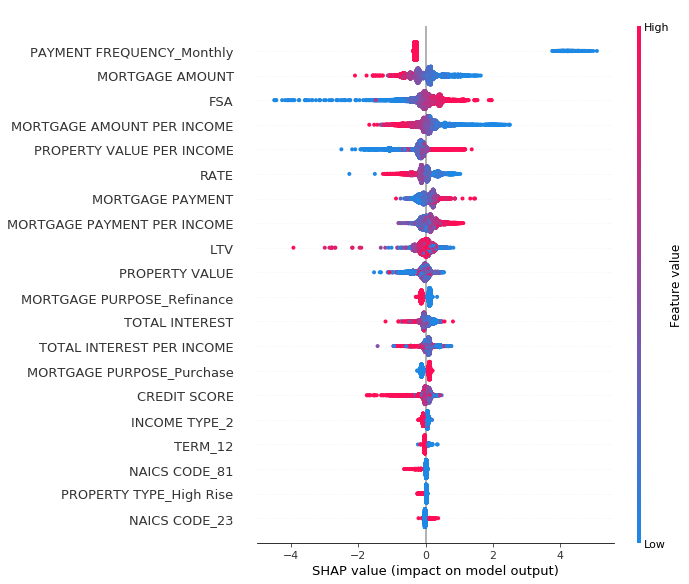

In [202]:
shap.summary_plot(shap_values, train[cnt_cols].iloc[test_index])

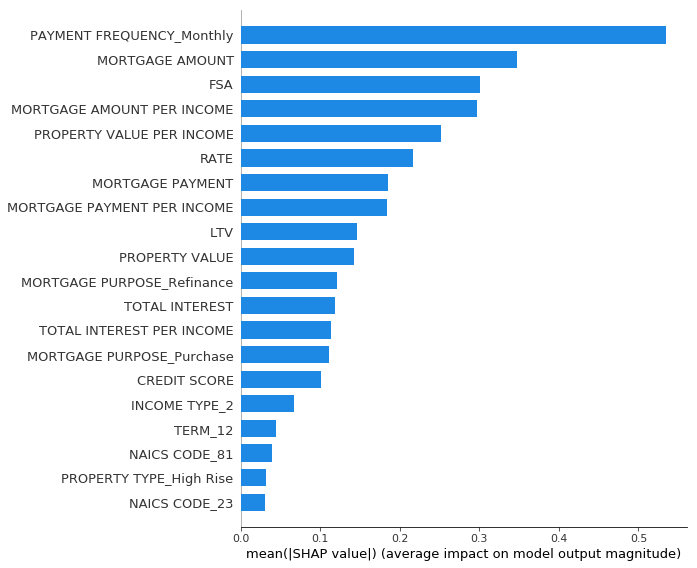

In [203]:
shap.summary_plot(shap_values, train[train_cols].iloc[test_index],plot_type='bar')

In [192]:
train_index

array([    0,     2,     3, ..., 45638, 45639, 45640])

In [193]:
test_index

array([    1,     5,     8, ..., 45631, 45633, 45641])

In [152]:
testpred = rf.predict(test[train_cols])

In [153]:
submission1 = pd.read_csv('../data/CAX_MortgageModeling_SubmissionFormat.csv')
submission1.Result_Predicted = testpred
submission1.head(3)
submission1.Result_Predicted = submission1.Result_Predicted.apply(lambda x: "FUNDED" if x == 1 else "NOT FUNDED")
submission1.Result_Predicted.value_counts(normalize=True)
submission1.to_csv('../submissions/submission1.csv',index=False)

,Unique_ID,Result_Predicted
0,CAX_Test_1,1
1,CAX_Test_2,1
2,CAX_Test_3,1


FUNDED        0.996714
NOT FUNDED    0.003286
Name: Result_Predicted, dtype: float64